# Prepare Environment

In [1]:
# to prepare the Python environment
import numpy as np
import scipy as sp
import scipy.constants as const
import pandas as pd
import os.path
import time
from scipy.optimize import curve_fit
from scipy import interpolate
import warnings
import gc

%matplotlib inline

# %reload_ext autoreload
# %autoreload 2

import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.ryfiles as ryfiles
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

from IPython.display import HTML
from IPython.display import Image
from IPython.display import display
from IPython.display import FileLink, FileLinks

import matplotlib as mpl
mpl.rc("savefig", dpi=72)
mpl.rc('figure', figsize=(10,8))
# %config InlineBackend.figure_format = 'svg'

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 150)

# suppress the pytables performance warning
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

# Introduction

In the visual spectral band, the detector signal is normally dominated by the optical flux from the target object and the path radiance (haze along the path). On a clear day the signal in the detector is almost 100% target object signal. 
In the thermal spectral bands the hot optics and any hot obscuration in the optical path also contribute to the signal accumulated in the pixel. The flux emission from these hot objects can be quite significant compared to the target emission.

At close range the atmosphere has limited effect on the target flux captured in the detector. At longer range the target flux is significantly affects by two atmospheric effects: (1) signal attenuation by absorption and scattering and (2) additive atmospheric flux from path radiance (atmospheric scattering and radiation into the line of sight).   As the atmospheric attenuation increases the path radiance also increases, resulting in a double hit on performance: the target flux (signal to noise) decreases and the path radiance flux (well fill) increases.  These effects become more prominent as atmospheric conditions degrades (poorer visibility and higher temperature and humidity).

This document investigates the relative contributions from the various sources of flux in the detector signal.  This composite flux is converted to electrical signals, digitised, processes and eventually displayed.  Once the flux is captured in the detector, the origins of the various contributions are lost: the detector only counts photons, irrespective of where it comes from.  The meaning that we as humans attach to the various contributions becomes irrelevant in the electronics.

Once the flux is detected and converted to a digital signal, the signal processing algorithms must attempt to remove the spurious flux sources and retain only the target object contribution.  For the most part this is easily done, simply by subtracting the more or less constant non-target portion from the total signal.  This is done by scanning the whole image and then subtracting the smallest pixel signal from all the pixels in the image. Easily done, but the effect of this procedure is that a significant portion of the usable dynamic range is lost in the process.

The pixel flux sources include:

1. Target flux, as propagated through the atmosphere (all sensors).
2. Atmospheric path radiance (all sensors).
3. Hot optics radiance in the unobscured clear aperture (all sensors).
4. The central obscuration radiance (SensorB and SensorC).

Clearly all flux/radiance contributions, except the target, must be minimised by design choices: cooling down, reflecting cold, or minimising the projected area.



## Assumptions

The calculations presented here are based on the following assumptions:

1. Only thermal emittance is considered for target/scene content and internal radiation content. The sun and its effect does not feature anywhere in this report.

2. The cold shield is assumed to be perfectly lambertian with unity emissivity.

3. The effect of external stray light outside the sensor field of view is not considered.

4. It is assumed that the sensor will be operated at 100% well fill for maximum scene radiance.  The well/gain selection and integration time will be adjusted to achieve 100% well fill if possible.  At maximum gain and maximum integration time the well fill will be less than 100%.

5. Signal processing is not considered in this report.

6. Noise in the signal and electronics is not considered in this report.

## Obscuration

Three configurations are considered:   without a central obscuration, with a central obscuration with matching f-numbers, and with a central obscuration with mismatching f-numbers.

## Read the input data

In [2]:
dolong = False
TempTargetDeltaC = 2.
TempDynamicPlot = 40.


In [3]:
# read the excel spreadsheet containing the sensor data and extract the example data

xfilename = 'data/well-fill/sensor-definitions.xlsx'

print('Input file: {}\n  created:       {}\n  last modified: {}\n\n'.format(xfilename,
                    time.ctime(os.path.getctime(xfilename)),
                    time.ctime(os.path.getmtime(xfilename))))

dfS = pd.read_excel(xfilename, 'Sheet1', index_col=None, na_values=['NA'])
dfS.set_index(keys='Index',inplace=True)
dfS.drop(labels=[-1],  inplace=True)
# get rid of empty lines
dfS.dropna(inplace=True)


dfsysCols = ['concept','sensor','fno', 'foclen m', 'hfov deg', 'tauopt', 
             'centralObs -', 'fnoColdshield', 
             'rprim m', 'rcentral m',
             'aprim m2', 'acentral m2','aclear m2', 
             'areaDetector m2','sizeDetector m','max IntTime s',
             'tempNETDStd K','netdstd K','wellCapacity','nuloss','wellCapacityUsable',
             'ksyss','spectralCent','spectralWid','spectralLo','spectralHi','quantumEff'
            ]
dfsys = pd.DataFrame(columns=dfsysCols)
concepts = dfS.columns.unique()
for column in dfS.columns:
    sensors = [s for s in dfS.loc['Sensor'][column].split(',')]
    for i,sensor in enumerate(sensors):
        rprim = [float(s) for s in dfS.loc['rprim'][column].split(',')]
        rcentral = [float(s) for s in dfS.loc['rcentral'][column].split(',')]
        foclen = [float(s) for s in dfS.loc['foclen'][column].split(',')]
        hfovdeg = [float(s) for s in dfS.loc['hfovdeg'][column].split(',')]
        tauopt = [float(s) for s in dfS.loc['tauopt'][column].split(',')]
        fnoColdshield = [float(s) for s in dfS.loc['fnoColdshield'][column].split(',')]
        fno = [float(s) for s in dfS.loc['fno'][column].split(',')]
        nuloss =  dfS.loc['nuloss'][column]
        
        aprim = np.pi * rprim[i] ** 2
        acentral = np.pi * rcentral[i] ** 2
        aclear = aprim - acentral
        areaDetector =  dfS.loc['sizeDetector'][column] ** 2
        spectralCent =  dfS.loc['spectralCent'][column]
        spectralWid =  dfS.loc['spectralWid'][column]
        quantumEff =  dfS.loc['quantumEff'][column]
        spectralLo =  spectralCent - spectralWid / 2.
        spectralHi =  spectralCent + spectralWid / 2.

        ocentral = acentral / aprim
               
        if type(dfS.loc['ksyss'][column]) is unicode:
            ksyss = [float(s) for s in dfS.loc['ksyss'][column].split(',')]
        else:
            ksyss = [float(dfS.loc['ksyss'][column])]
        
        if type(dfS.loc['wellCapacity'][column]) is unicode:
            wellCapacity = [float(s) for s in dfS.loc['wellCapacity'][column].split(',')]
            wellCapacityUsable = [float(s) * (1.0-nuloss) for s in dfS.loc['wellCapacity'][column].split(',')]
        else:
            wellCapacity = [float(dfS.loc['wellCapacity'][column])]
            wellCapacityUsable = [float(dfS.loc['wellCapacity'][column])* (1.0-nuloss)]

        restults = [column, sensors[i], fno[i], foclen[i], hfovdeg[i], tauopt[i], 
                    ocentral, fnoColdshield[i], 
                    rprim[i], rcentral[i],  aprim, acentral, 
                    aclear, areaDetector,
                    dfS.loc['sizeDetector'][column], dfS.loc['integrationTime'][column],
                    dfS.loc['tempNETDStd'][column], dfS.loc['netdstd'][column], 
                    wellCapacity, nuloss, wellCapacityUsable, ksyss, 
                    spectralCent, spectralWid, spectralLo, spectralHi, quantumEff]

        dfsys = dfsys.append(pd.DataFrame([restults], columns=dfsysCols))

# build a multi-index for concepts and sensors
dfsys.index = pd.MultiIndex.from_tuples([(v['concept'],v['sensor']) for k,v in dfsys.iterrows()])
# transpose and clean up
dfsys=dfsys.transpose().drop(['concept','sensor'])

print('All available concepts:')
print(concepts)
print(' ')

# filter all sensors of given concept
Cconcept = u'MWIR Sensor'

dfConcept = dfsys[Cconcept].copy()
CSensors = dfConcept.columns.values

print('Selected concept and sensor definitions:')
print(Cconcept)
print(dfConcept)
# get one sensor from one concept
# print(dfConcept[CSensors[0]])   
#get particular value for specific variable of given sensor and concept
# print(dfConcept[CSensors[0]]['fno'])   

sizeDetector = dfConcept[CSensors[0]]['sizeDetector m']
integrationTime = dfConcept[CSensors[0]]['max IntTime s']
areaDetector = dfConcept[CSensors[0]]['areaDetector m2']
wellCapacityUsable = dfConcept[CSensors[0]]['wellCapacityUsable']
netdstd = dfConcept[CSensors[0]]['netdstd K']
tempNETDStd = dfConcept[CSensors[0]]['tempNETDStd K']
ksyss = dfConcept[CSensors[0]]['ksyss']
threshold2Noise = 1.



Input file: data/well-fill/sensor-definitions.xlsx
  created:       Wed Oct 19 10:16:27 2016
  last modified: Wed Oct 19 10:16:27 2016


All available concepts:
[u'MWIR Sensor']
 
Selected concept and sensor definitions:
MWIR Sensor
                        SensorA      SensorB      SensorC
fno                           4            4            6
foclen m                    0.6          0.6          0.6
hfov deg                   0.91         0.91         0.91
tauopt                      0.8         0.74         0.74
centralObs -                  0       0.0625       0.0625
fnoColdshield                 4            4            4
rprim m                    0.08          0.1          0.1
rcentral m                    0        0.025        0.025
aprim m2              0.0201062    0.0314159    0.0314159
acentral m2                   0    0.0019635    0.0019635
aclear m2             0.0201062    0.0294524    0.0294524
areaDetector m2        2.25e-10     2.25e-10     2.25e-10
sizeDetector 

Although three sensors are defined above, only SensorA is evaluated in the default mode in this notebook. This is done to limit the execution time and download size, because each additional sensor adds time and a large download file.

## Cold Shield

The detector can receive flux propagating through the clear optics (the intended signal) but also from the optomechanical mounting components such as the optical barrel (undesired signal).  The designer's objective is to maximise the intended signal and to minimise the undesired signal in order to minimise detector well fill with non-signal.

Cold stop efficiency is defined as the ratio of flux in the optical f-number cone (i.e., inside the solid angle subtended by the exit pupil) to total flux on the detector. If there is no vignetting in the system the flux in the exit pupil will be the flux entering the entrance pupil.  In the ideal case the cold stop efficiency should  be 100%.

Flux loss/contribution attributable to vignetting is not included in the cold stop efficiency merit, because only the flux in the exit pupil is considered.

### Cold shield - intermediate focal plane 

The more sophisticated two-image-plane design specifically focuses (re-images) the entrance pupil onto the cold shield, i.e., the exit pupil is the cold shield aperture.  The flux that enters the cold stop can therefore only come from the exit pupil, no other flux emanating behind the exit pupil can reach the detector.  This means that only flux (1) entering the entrance pupil plus flux (2) that emanates inside the clear optics areas can reach the detector.

This optical design has three focusing objectives: (1) the object is imaged onto the intermediate focal plane, (2) the intermediate focal plane is focused onto the detector, and (2) the exit pupil is focused onto the cold stop.  Lens 2 therefore has two focussing tasks.

This optical design is more complex than the single lens design shown before, but has the benefit of achieving a 100% cold stop efficiency.  The multiple objectives with this design, especially with respect to lens 2, place some constraints on the design.


![''](images/coldshield-ineff-concept.png)

![''](images/coldshield-ineff-concept2.png)


### Cold shield distance

The distance between the cold shield and the detector is important.  

In a simple single-focal-plane (Bill Wolfe) design the closer the cold shield is moved towards the exit pupil the better the cold efficiency becomes. This is demonstrated in the graph in the Bill Wolfe extract above.  In the case of the single-focal-plane design the cold shield efficiency is improved by increasing the distance between the detector and the cold shield.

In a the two-focal-plane design that images the exit pupil onto the cold shield the cold shield efficiency is 100% irrespective of the distance between the detector and the cold shield.  However, in this case the cold shield distance remains important: if the distance is too short the optical angles in the exit pupil becomes large complicating the optical design and manufacture.  This cold stop distance constraint has nothing to do with the cold shield efficiency.

## Scene and sensor variations

A large number of variations are considered in this report:

1. Two filter configurations are investigated: a single band response and a filter with a notch around 4.3~$\mu$m.  The notch filter suppresses the path radiance at 4.3 $\mu$m, but is also a little wider towards the shorter wavelength range.  This extra width towards shorter wavelengths attempts to gather more target signal.  The effect of the notch filter is evident at longer ranges as the path radiance increases.

1. Atmospheric transmittance and path radiance play significant roles in the detector electron well fill, particularly under poor atmospheric conditions.   For this reason several atmospheric conditions are considered in this analysis.

1. The background (ambient) temperature also has a significant effect on the target contrast: at cold temperatures the signature contrast is smaller.  Several values of ambient temperature are considered in the analysis.  

1. Several different internal temperature differentials relative to ambient outside temperatures are considered.  When the equipment is switched on the differential will be zero, but after prolonged operation, an internal temperature rise of 20 C or even 40 C can be expected.  The higher temperatures have significant effect on the radiation from the optics and obscurations.

All these variations result in a multidimensional grid, from which only a few cases a shown in graphical form.


The target and sensor internal temperatures are all calculated relative to some baseline temperature. This reference-based approach enables us to evaluate the effect of scene or sensor ambient temperature variations.

Note that the internal sensor temperature is calculated relative to the outside atmospheric temperature: at higher altitudes the internal sensor temperature will be cooler than at lower outside atmospheric temperatures.
In the detailed analysis various combinations of element temperatures are considered.  The temperatures are mostly given as deltas from some reference temperatures.  The reference temperatures are the cold shield temperature (assumed 100 K) and the scene temperature.  There are two scene temperature models: 

- Horizontal paths with temperatures from very cold to very hot.

- Slant paths not further modelled in this notebook.

The target temperature is defined as a delta relative to the scene temperature.    Typical scene temperature contrast in outdoor scenes ranges from 40 K to 60 K (or even higher).

The atmospheric temperature is derived from the scene temperature.  For the horizontal paths, the atmospheric temperature is the same as the scene temperature.  For a slant paths the atmospheric temperature is determined from the vertical profile for the respective atmospheric models.

The sensor internal temperature is derived from the atmospheric temperature with some delta temperature.  The $-100$ K case represents an ideal ice-cold internal temperature (no background flux from the sensor).  The $0$ K case represents the case where the internal temperature is the same as the outside temperature.  The other two cases represent a hot sensor, compared to the atmosphere around the sensor.

The optics temperature is at zero delta to the internal temperature.

The hot shield  temperature can be cooler than the interneal temperature, if  the mechanics is reflecting the cold detector onto itself.  This value is motivated as follows:  the hot shield and central obscuration will be designed to reflect the detector cold stop. This reflection is however not optically perfect, there will be inefficiencies, reflecting some portion of the sensor internal optomechanical radiance.  The (ineffective) detector reflection will however lower the flux to some degree, hence the -100 C temperature delta.

The specific variations in the temperatures are given below in  `tempCentralObsDeltas`, `tempHotShieldDeltas`, `TempAmbient`, `TempScene`, and `TempInsideDelta`. 
The path lengths considered are given below in `pathlenUniqueGen`.


![''](images/temperature-series.png)

## Graph definitions

Almost all the graphs in this show percentage well fill, which is the *signal collected in a single pixel*, say the central pixel in the image. The 'well' a small capacitor under the detector element that accumulates electrons during the integration time.  
Some detectors have single valued well capacities while others have selectable well capacity values, expressed in electrons.
The well capacity is reduced by the non-uniformity margin, so in practice and in these calculations, the effective well capacity is somewhat smaller than the nominal design value.

For shorter integration times less electrons will be collected and for longer integration times more electrons are collected. There is a maximum integration time, determined by the frame rate.  For this investigation the maximum integration time is assumed to be 19~ms, but it is can be any smaller value.

When calculating the well fill, the best combination of well capacity and integration is used to achieve the highest well fill (but limited to 100%).   the well fill is calculated such that a minimum dynamic range is maintained in the image. For example, most cases consider the case where the temperature difference between the hottest and coldest objects in the scene (dynamic range) differs by 40 K.  This means that the well selection and integration is such that the hottest pixel fills the well to 100%.  

The dynamic range is not the target temperature.  Somewhere in this dynamic range is the target contrast (for example 2 K).  

![''](images/well-fill-01.png)

The graph above shows an annotated graph explaining the various contributors to well fill, color coded as defined in the graph legend. The legend also shows the delta temperature for the specific contributor, relative to its reference temperature. This particular graph does not show photon starvation because the well is always 100% filled. For well fill the graph uses the y-axis scale on the left (100% maximum).

The available well capacity after allowance for the non-uniformity is shown near the bottom of the graph along the x-axis.  Also shown is the integration time required to achieve the well fill shown in the stacked graph.  The image dynamic range (i.e., 40 K) is shown on the top left of the graph.

The graph   shows well fill versus target distance for a fixed sensor dynamic range setting.  The graph below also shows the bits lost to noise (dash-dot line) for a TNR=1 (i.e., RMS noise).  The solid line shows the number of bits not available for signal: loss attributable FPA nonuniformity, hot optics well fill and scene minimum radiance well fill (yellow, cyan, magenta, green and red in the graph).  The dashed line shows the number of useful bits left for scene radiance above the minimum level, i.e., the dynamic range in the image.  The three bit lines map to the scale on the right (14 bits).

Other graphs show well fill for increasing target contrast at a fixed target distance. For both graph-types the elements' descriptions are the same as shown in the above graph.

The calculations yield fractional bits resulting from floating point calculations, to be considered as statistical values over large samples.



## Non uniformity effect on dynamic range

The detector specfications state quite high values of detector non-uniformity, up to 25% from the mean value.  In order to allow headroom for the more responsive detector elements the integration time must be shortened such that the more responsive detector elements do not saturate.  This means that the available well capacity for the mean signal is reduced.

![''](images/nu-well-fill01.png)

In the calculations below the available well capacity is calculated as 

\begin{equation}
W_\textrm{available} = W_\textrm{true} - (1-NU)
\end{equation}
where
$W_\textrm{true}$ is the specified well capacity, and 
$NU$ is the per unit non-uniformity, i.e., 0.25.  The value for NU used in the calculation is read in per detector from the input data file.

The number of bits lost to non-uniformity margin is given by $\log_2(1-NU)$.
An NU of 0.25 results in a bit loss of 0.42 bits.
An NU of 0.15 results in a bit loss of 0.23 bits.


## Signal dynamic range

The signal dynamic range can be expressed in terms of bits of a binary word.  The effect of well fill is to reduce the number of bits from the most-significant end of the word: a 50% well fill removes the MSB and so down.  
The number of bits available to the target scene, after well fill by the hot optics, internal sensor stray radiation and path radiance is shown in the figure below and in the following equation:

![''](images/well-fill-05.png)

The word length so obtained is shown in the graphs above: the target percentage of well fill was used to determine the number of bits available to represent the target contrast temperature. Well fill and non-uniformity margin reduces the number of bits from the most significant bit end.

Noise, EMI and roundoff errors in signal processing reduce the dynamic range from the least-significant bit end. This is accounted for in the present study as follows:

1. The detector NETD is modified by the ambient conditions, as described in Section~\ref{netdmodambient}.  Under higher temperature background conditions the noise  increases (but NETD decreases) and under colder background conditions the noise decreases (NETD increases).
2. A small amount of system noise is added to the detector NETD. This noise is constant and independent of ambient conditions.  Presently the assumed system noise increases the NETD by about 20% at 293 K.
3. The noise 'floor' is taken at a threshold to noise ratio (TNR) of one, i.e., the RMS noise value. In practice a higher of TNR (five to eight) would be required for low-false alarm signal detection.  The TNR=1 value used here is motivated on the grounds that the human vision system somewhat averages out the noise over multiple frames.

The number of bits available to represent the target is under pressure from both the well fill end and the noise end --- squeezed somewhere in the middle.  Once the top and bottom bits have been removed, the image processing takes place on the centre bits --- but this processing will also introduce bit loss, because of linear and nonlinear scaling and repeated integer resolution processing.

It is important that the hardware design should strive to provide maximal dynamic range for image processing and 
reduce the pressure from both ends: minimise hot optics and noise/EMI/NUC bit loss.

Seen from this perspective, a 50% well fill is not so severe as originally thought.  A 50% well fill does not remove half the number of bits available for the target, it only removes  $-\log_2(W)=1$ bits (where $W$ is the fractional well fill).
However, the detector and sensor noise effectively removes two to four bits on the bottom end, resulting in an overly small number of bits in the useful image.

In most of the graphs presented in this report the scene dynamic range is 40 K temperature contrast (the hottest object in the image) and the target has a 2 K contrast.  The gain was calculated such at a 40 K temperature contrast object would result in a 100% well fill.  In the same image the 2 K target would then fill a smaller percentage of the well capacity.

![''](images/adc-dynamic-range.png)

The work presented in this report shows that the internal sensor radiance present a signal larger than the target. All efforts must therefore be expended to minimise hot optics self-radiance and optical path obscuration radiance.

# Sensor Filter

Two filters are considered: one with a CO$_2$ notch filter and one without.  The notch filter is intended to filter out the spectral region where there is no/little target signal, thereby suppressing some of the sensor and path radiance contributions.  In  the graphs in this document the single band filter is identified in the graph titles by the name `Standard`, whereas the use of notch filter is identified by the name  `Notch`.

The spectral width of the filter is adapted according to the detector specification given in the input data file.

In [4]:
# to define the generic atmospheres: code, description and temperature
atmodef = zip(['MLS23km','tropical5km','SW31km'],
              ['Midlatitude Summer, 23 km Urban vis','Tropical, 5 km Urban vis',
               'Scandinavian Winter 31 km vis Navy Maritime'],
              [294., 300., 257.])

#generic atmosphere data are used to extract the wavelength vector for calculations
#get the wavenumber and wavelength vectors from the first atmo file
wn =  rymodtran.loadtape7("data/well-fill/{}/tape7".format(atmodef[0][0]), ['FREQ'] ).reshape(-1,)
wl = 1e4 / wn# convert from wavenumber to wavelength

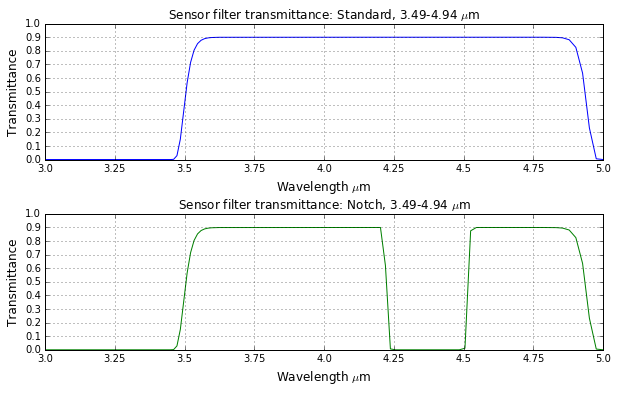

In [5]:
# to define the filter spectral transmittance
TauFilters = np.zeros((wl.shape[0],2))
optFilters = ['Standard','Notch']

specCent = dfConcept[CSensors[0]]['spectralCent']
specWid = dfConcept[CSensors[0]]['spectralWid']

#3.4-4.9
# TauFilters[:,1] = ryutils.sfilter(wl, 4.15, 1.45, exponent=40, taupass=0.9, taustop=0.0, filtertype = 'bandpass') 

#3.7-4.8
TauFilters[:,0] = ryutils.sfilter(wl, specCent, specWid, exponent=40, taupass=0.9, taustop=0.0, filtertype = 'bandpass')
TauFilters[:,1] = ryutils.sfilter(wl, specCent, specWid, exponent=40, taupass=0.9, taustop=0.0, filtertype = 'bandpass') - \
            ryutils.sfilter(wl, 4.37, .3 , exponent=40, taupass=0.9, taustop=0.0, filtertype = 'bandpass')

p = ryplot.Plotter(1,2,1,figsize=(10,6))
for i,optFilter in enumerate(optFilters):
    p.plot(1+i,wl,TauFilters[:,i],'Sensor filter transmittance: {}, {:.2f}-{:.2f} $\mu$m'.format(optFilter,
            dfConcept[CSensors[0]]['spectralLo'],dfConcept[CSensors[0]]['spectralHi']), 'Wavelength $\mu$m',
           'Transmittance'); 
    
# dfF = pd.DataFrame(TauFilters, columns=['Standard','Notch'])    
# dfF['Wavelength']  = wl
# writer = pd.ExcelWriter('MWIR-filters.xlsx')
# dfF.to_excel(writer,'Filters')
# writer.save()


# Atmospheric Transmittance and Path Radiance

The generic atmospheres are based on two horizontal-path atmospheres (moderate and poor visibility) from which a variety of derived atmospheric conditions are calculated. The horizontal path model assumes that the atmosphere is uniform along the path.  The atmospheric transmittance is scaled according to the required path length.  The path radiance is furthermore adapted to the respective atmospheric variation.  For cooler variations the path radiance is reduced and for warmer atmospheres the path radiance is increased.  Hence, the path radiance is always relevant to the ambient temperature in the scenario.   The generic atmospheric model is therefore manipulated to estimate the transmittance and path radiance over a multidimensional grid of scenario values.


## Generic Atmospheres

In this analysis three atmospheric conditions are modelled by Modtran: (1) a very poor atmosphere with Tropical climatic conditions (27 C and 75% relative humidity) and a 5 km visibility Modtran Urban aerosol, (2) a moderate atmosphere with Midlattitude summer climatic conditions (21 C and 76% relative humidity) and a 23 km visibility Urban aerosol, and a good atmoshere with Subarctic Summer (-16C,  80% RH) and 31 km Marine aerosol visibiity aerosol.

The path radiance graphs below show the fit of a Planck radiance curve to the path radiance curve.  It is evident that when the atmospheric transmittance is zero, the path radiates as a blackbody.  At wavelengths where the transmittance is not zero the path radiates with an emissivity of (1-$\tau$).  

In the subsequent calculations the path radiance will be calculated as the the product of $(1-\tau_a)$ times the Planck radiance at the atmospheric temperature.   Atmospheric temperature is assumed equal to the ambient temperature --- this assumption is based on the observation that the atmospheric temperature is normally within  a few degrees around ambient temperature.

Midlatitude Summer, 23 km Urban vis, 5 km path length
Modtran path radiance 1.15e+00 W/(m2.sr)
Modtran path radiance 2.62e+19 q/(s.m2.sr)
(1-tau) path radiance 2.60e+19 q/(s.m2.sr)
 
Tropical, 5 km Urban vis, 5 km path length
Modtran path radiance 1.57e+00 W/(m2.sr)
Modtran path radiance 3.56e+19 q/(s.m2.sr)
(1-tau) path radiance 3.60e+19 q/(s.m2.sr)
 
Scandinavian Winter 31 km vis Navy Maritime, 5 km path length
Modtran path radiance 1.91e-01 W/(m2.sr)
Modtran path radiance 4.34e+18 q/(s.m2.sr)
(1-tau) path radiance 4.30e+18 q/(s.m2.sr)
 


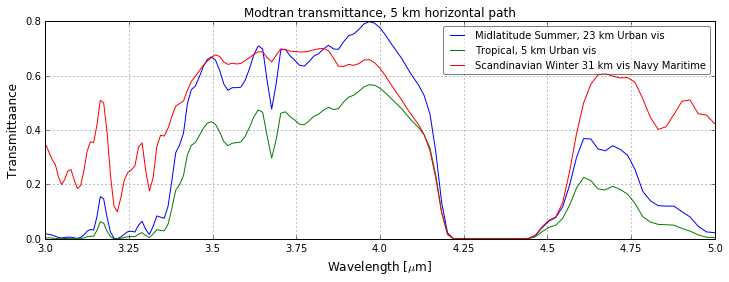

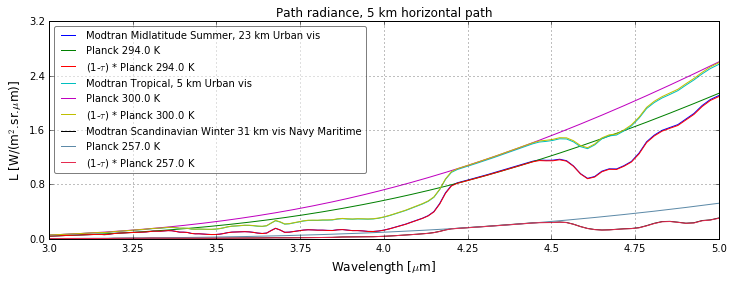

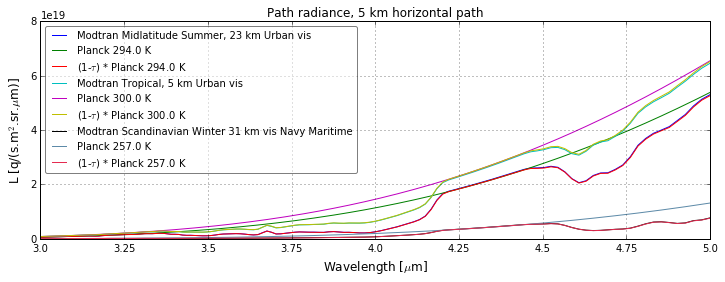

In [6]:
# to plot selected atmospheric transmittance and path radiance values
sr = ryplot.Plotter(1,1,1,figsize=(12,4));
ss = ryplot.Plotter(2,1,1,figsize=(12,4));
st = ryplot.Plotter(3,1,1,figsize=(12,4));

for i, (atmo, atmoDesc, tempModAtmo) in enumerate(atmodef):

    colSelect =  ['FREQ', 'TOT_TRANS', 'TOTAL_RAD']
    skyrad= rymodtran.loadtape7("data/well-fill/{}/tape7".format(atmo), colSelect )

    TauAtmo = skyrad[:,1]
    wl, LpathW = ryutils.convertSpectralDensity(skyrad[:,0],skyrad[:,2],'nl')
    LpathW = 1.0e4 * LpathW # /cm2 units to /m2 units
    LpathQ = LpathW  / (ryplanck.const.h * ryplanck.const.c / (wl.reshape(-1,1) * 1e-6))

    if i == 0:
        gammaTau = -np.log(TauAtmo).reshape(-1,1) / 5.0 # units of km-1
    else:
        gammaTau = np.hstack((gammaTau, -np.log(TauAtmo).reshape(-1,1) / 5.0))
    
    sr.plot(1,  wl, TauAtmo, "Modtran transmittance, 5 km horizontal path","Wavelength [$\mu$m]","Transmittaance",
         label=[atmoDesc],legendAlpha=0.5, maxNX=10, maxNY=4);
    ss.plot(1,  wl, LpathW, "","","",
         label=['Modtran {}'.format(atmoDesc)],legendAlpha=0.5, maxNX=10, maxNY=4);
    ss.plot(1,  wl, ryplanck.planck(wl,tempModAtmo,type='el')/np.pi, "","","",
         label=['Planck {} K'.format(tempModAtmo)],legendAlpha=0.5, maxNX=10, maxNY=4);
    ss.plot(1,  wl, (1-TauAtmo)*ryplanck.planck(wl,tempModAtmo,type='el')/np.pi, "Path radiance, 5 km horizontal path","Wavelength [$\mu$m]","L [W/(m$^2$.sr.$\mu$m)]",
         label=['(1-$\\tau$) * Planck {} K'.format(tempModAtmo)],legendAlpha=0.5, maxNX=10, maxNY=4);

    st.plot(1,  wl, LpathQ, "","","",
         label=['Modtran {}'.format(atmoDesc)],legendAlpha=0.5, maxNX=10, maxNY=4);
    st.plot(1,  wl, ryplanck.planck(wl,tempModAtmo,type='ql')/np.pi, "","","",
         label=['Planck {} K'.format(tempModAtmo)],legendAlpha=0.5, maxNX=10, maxNY=4);
    st.plot(1,  wl, (1-TauAtmo)*ryplanck.planck(wl,tempModAtmo,type='ql')/np.pi, "Path radiance, 5 km horizontal path","Wavelength [$\mu$m]","L [q/(s.m$^2$.sr.$\mu$m)]",
         label=['(1-$\\tau$) * Planck {} K'.format(tempModAtmo)],legendAlpha=0.5, maxNX=10, maxNY=4);

    LpathQQ = np.trapz((1.0-TauAtmo).reshape(-1,1) * ryplanck.planck(wl,tempModAtmo,type='ql').reshape(-1,1)/np.pi,x=-wl.reshape(-1,1),axis=0)

    print('{}, 5 km path length'.format(atmoDesc))
    print('Modtran path radiance {:.2e} W/(m2.sr)'.format(np.trapz(LpathW,x=-wl.reshape(-1,1),axis=0)[0]))
    print('Modtran path radiance {:.2e} q/(s.m2.sr)'.format(np.trapz(LpathQ,x=-wl.reshape(-1,1),axis=0)[0]))
    print('(1-tau) path radiance {:.2e} q/(s.m2.sr)'.format(LpathQQ[0]))
    print(' ')


# Sensor Radiometry Calculations

The contribution of various flux sources can be calculated from first principles.  Of course, it is very difficult to be completely correct, but order of magnitude results can be readily obtained with a little care.  More detail on the radiometric theory used here can be obtained in 'Electro-Optical System Design; A Radiometric Perspective', by CJ~Willers, SPIE, 2013.

In the analysis done here, the effect of the atmosphere is included in terms of target flux attenuation and atmospheric path radiance.  Both factors play a significant role in the pixel well fill, particularly under poor atmospheric conditions or for long distance paths.

For any optical medium $\epsilon + \rho + \tau=1$, where $\epsilon$ is the medium emissivity, $\rho$ is the medium reflectance and $\tau$ is the medium transmittance.  Opaque surfaces has $\tau=0$ and hence $\epsilon = 1 - \rho$. Non-reflective surfaces have
$\epsilon = 1 - \tau$.  Optical elements have emissivity, reflectance and transmittance and this simple analysis is not appropriate.  The lens elements will reflect the ambient barrel radiance $\rho L_{\textrm{barrel}}$ and will emit $\epsilon L_{\lambda\textrm{optics}}$.


![''](images/Radiometry12.png)

**Optical design has zero narcissism:**  
The total flux emanating from the lens elements will be
$\Phi=
\Omega_{f}A_o\left[
\tau_{\textrm{o}} L(T_{\textrm{object}})
+
\epsilon_{\textrm{o}} L(T_{\textrm{optics}})
+
\rho_{\textrm{o}} L(T_{\textrm{barrel}})
\right]
$.  Assuming that the barrel and optics are at the same temperature $T_{\textrm{optics}}=T_{\textrm{barrel}}$,
then 

\begin{equation}
\Phi
=
\Omega_{f}A_o\left[
\tau_{\textrm{o}} L(T_{\textrm{object}})
+
\epsilon_{\textrm{o}} L(T_{\textrm{optics}})
+
\rho_{\textrm{o}} L(T_{\textrm{optics}})
\right]
=
\Omega_{f}A_o\left[
\tau_{\textrm{o}} L(T_{\textrm{object}})
+
 L(T_{\textrm{optics}})(\epsilon_{\textrm{o}}+\rho_{\textrm{o}})
\right],
\end{equation}
but 
$(\epsilon_{\textrm{o}}+\rho_{\textrm{o}}) L(T_{\textrm{optics}}) = (1-\tau_{\textrm{o}})L(T_{\textrm{optics}})$. Then


\begin{equation}
\Phi
=
\Omega_{f}A_o\left[
\tau_{\textrm{o}} L(T_{\textrm{object}})
+
 L(T_{\textrm{optics}})(1-\tau_{\textrm{o}})
\right]
\end{equation}

Hence the optics' `effective emissivity' can be considered as everything that is not transmittance, leading to the simple model
$\epsilon_{o\lambda} = 1 -  \tau_{\lambda o}$, and similarly for the filter
$\epsilon_{f\lambda} = 1 -  \tau_{\lambda f}$.  This model only applies if $T_{\textrm{optics}}=T_{\textrm{barrel}}$.


**Optical design has nonzero narcissism:**  

Narcissism is the detector reflected from the optics' elements' surfaces onto itself.  If is modelled as a scalar reflective term $\rho_n$, computed over the full optics aperture, for different field angles. The value  of $\rho_n$ is determined by ray tracing, counting the fraction of rays emanating from the detector, that fall back onto the detector.  The object transmittance and the optics' self emittance is not affected by the narcissism and remains the same.  The reflectance from the optics now has two components, the reflected narcissism component and the reflected barrel component.

With narcissism present the total flux emanating from the lens elements will be

\begin{equation}
\Phi=
\Omega_{f}A_o\left[
\tau_{\textrm{o}} L(T_{\textrm{object}})
+
\epsilon_{\textrm{o}} L(T_{\textrm{optics}})
+
(\rho_{\textrm{o}} - \rho_{\textrm{n}}) L(T_{\textrm{barrel}})
+
\rho_{\textrm{n}} L(T_{\textrm{cold}})
\right].
\end{equation}

Assuming that the barrel and optics are at the same temperature $T_{\textrm{optics}}=T_{\textrm{barrel}}$ and $(\epsilon_{\textrm{o}}+\rho_{\textrm{o}}) L(T_{\textrm{optics}}) = (1-\tau_{\textrm{o}})L(T_{\textrm{optics}})$,
then 

\begin{equation}
\Phi
=
\Omega_{f}A_o\left[
\tau_{\textrm{o}} L(T_{\textrm{object}})
+
(1-\tau_{\textrm{o}})L(T_{\textrm{optics}})
- \rho_{\textrm{n}}\left[L(T_{\textrm{barrel}}) - L(T_{\textrm{cold}})\right]
\right].
\end{equation}

$\left[L(T_{\textrm{barrel}}) - L(T_{\textrm{cold}})\right]$ can be significantly large for a cryogenically cooled detector, and therefore, even small amounts of narcissism reflectance can contribute to the reducing the flux on the detector.


The interplay between obscuration emissivity and lens transmittance is shown in the diagram below.
Until analysed in more detail later, a simplified approach is taken where:

1. The relative (percentage) contributions used in the analysis below are given by the projection of the respective obstructions in the pupil.
2.  A single lens approximation is used where the lens radiance emanates from  a single element in the pupil.
3. The obstruction is located between the lens and the detector, partially obscuring the lens radiance (the second obscuration shown below). Obscuration elements therefore contribute the maximum possible radiance.  If the obscuration, optics and barrel are all at the same temperature, this approximation is a reasonable assumption.  If the obscuration elements were located in front of the lens, $(1-\epsilon_o - \rho_o)L(T_{\textrm{barrel}})$ will be transmitted, an $\epsilon_o L(T_{\textrm{barrel}})$ will be emitted and $\rho_o L(T_{\textrm{barrel}})$  will reflect from the optical barrel, adding up to the radiance of an obscuration located behind the lens.

The contribution of various elements to the total flux on the detector can be calculated from the elements' solid angles and radiances within each solid angle.  For the first order analysis we assume that the elements' radiance values are uniform in the elements' solid angle. If the radiating sources are not uniform, the values used here can be considered the mean values of the respective radiators.

The model shown here calculates the flux on the central pixel in the image. The values for other pixels will be slightly different, resulting from different solid angles to these pixels.

The elements identified in this analysis and their relative contributions are shown in the following figure:

![''](images/Radiometry16.png)

The absolute well fill is calculated as follows:
    
\begin{equation}
W_f = 100 \, \eta\, E_{\textrm{det}}\, A_d\, t_i \,/ \,W_c
\end{equation}
where
$\eta$ is the detector quantum efficiency, 
$W_f$ is the actual well fill percentage, 
$E_{\textrm{det}}$ is the irradiance on the detector, 
$A_d$ is the area of the detector, 
$t_i$ is the integration time, and 
$W_c$ is total well capacity of the detector integration capacitor.


## NETD degradation\label{netdmodambient}


### Detector NETD components

The detector noise can be expressed as a noise variation around some nominal background temperature.  The NETD noise formulation is a derived form of noise, and hence not directly measureable or provable.

The detector noise comprises two components: a scene-flux-induced noise (inherent in the signal, non uniformity) and a detector electronics component (read noise, etc.).  In the present analysis we do not include the sensor's electronics noise, that will be considered later in the analysis.


Assume here that the detector electronics noise adds in quadrature to the detector schene flux noise. This is approximately true if the electronics noise is uncorrelated with the detector noise.  The effective detector NETD is then given by

\begin{equation}
NETD_\textrm{eff} = \sqrt{NETD^2_\textrm{BLIP}+NETD^2_\textrm{elec}+NETD^2_\textrm{sys}}
\end{equation}
where 
$NETD_\textrm{BLIP}$ is the scene-induced noise, 
$NETD^2_\textrm{elec}$ is the detector electronics noise, and
$NETD^2_\textrm{sys}$ is the system electronics noise.


### Background limited NETD

This derivation starts from first principles to find an allowable mechanism whereby the detector supplier's NETD can be adjusted for different scene and internal temperatures.  The idea is to use the supplier's measured/specification information and then to rescale to different conditions.  The approach used here uses the supplier's NETD at 50% well fill, but does not account for changes in the well fill for the new conditions.  Strictly speaking this is not correct, but it is considered adequate for the present analysis.

The noise equivalent target contrast (NETC) is the target temperature change required to overcome the noise in the sensor.  A larger NETC is worse, a smaller NETC is better.  The NETC is calculated in kelvin or degrees Celcius  from:

\begin{equation}
{NETC_\textrm{BLIP}}=
\frac{\sqrt{\eta_a\eta_b k_n k_f \Omega_r F_F }\;4 f^2_\textrm{no}}
{\Omega_p\sqrt{N}\;P f   }\cdot
\frac{1}{\int_0^\infty D^{\ast}_{\lambda} \tau_{\lambda s} \epsilon_\lambda \tau_{\lambda a} \frac{d {M_{\lambda}}(T_t)}{d T}d\lambda} 
\end{equation}


where
$\sqrt{\eta_a\eta_b}$ is the staring array fill factor [-],
$k_f$ is the sensor's time bandwidth product,
$k_n$ is the ratio of sensor's noise bandwidth to the -3 dB electronics bandwidth,
$\Omega_r$ is the total field of regard/view solid angle [sr],
$F_F$ is the frame frequency [Hz], 
$f^2_\textrm{no}$ is the f-number [-],
$\Omega_p$ is the pixel field of view solid angle [sr],
$N$ is the number of detectors [-], 
$P$ is fraction unobscured optical aperture [-], 
$f$ is the focal length [m], 
$D^\ast_{\lambda}$ is the spectral detector material detectivity [m $\sqrt{\textrm{Hz}}$/W] (note that the dimensional unit centimeters is normally used instead of meters),
$\epsilon_\lambda$ is the spectral target emissivity [-], 
$\tau_{\lambda s}$ is the spectral sensor optical transmittance [-], 
$\tau_{\lambda a}$ is the spectral atmospheric optical transmittance [-], 
and 
$\frac{d {M_{\lambda}}(T_t)}{d T}$ is the spectral derivative of the apparent source exitance with respect to the source temperature; in other words, the rate at which the apparent source exitance changes for a given change in source temperature. 
In this calculation the effect of sun irradiance is not accounted for, the predicted performance would be for night time operation.

In a sensor with viewing hot optics, an atmospheric path, and a scene, the $D^\ast_{\lambda}$ depends on sensor internal self radiance, and is given by 
\begin{equation}
\frac{\lambda\eta_\lambda}
{hc\sqrt{2}\sqrt{ \int_0^{\lambda_c}\eta_\lambda E_q d \lambda}}
\end{equation}
where
$\eta_\lambda$ is the spectral quantum efficiency and 
$E_q$ is total flux on the detector.  
Then the NETC is given by 
\begin{equation}
{NETC_\textrm{BLIP}}=
\frac{\sqrt{\eta_a\eta_b k_n k_f \Omega_r F_F }\;4 f^2_\textrm{no}}
{\Omega_p\sqrt{N}\;P f   }\cdot
\frac{hc\sqrt{2}}{\int_0^\infty \left[\left(\frac{\lambda\eta_\lambda}
{\sqrt{ \int_0^{\lambda_c}\eta_\lambda E_q d \lambda}}
\right) \tau_{\lambda s} \epsilon_\lambda \tau_{\lambda a} \frac{d {M_{\lambda}}(T_t)}{d T}\right]d\lambda} 
\end{equation}


\begin{equation}
{NETC_\textrm{BLIP}}=
\frac{\sqrt{\eta_a\eta_b k_n k_f \Omega_r F_F }\;4 f^2_\textrm{no}}
{\Omega_p\sqrt{N}\;P f   }\cdot
\frac{hc\sqrt{2 \int_0^{\lambda_c}\eta_\lambda E_q d \lambda}}
{\int_0^\infty \lambda\eta_\lambda
 \tau_{\lambda s} \epsilon_\lambda \tau_{\lambda a} 
\frac{d {M_{\lambda}}(T_t)}{d T}d\lambda} 
\end{equation}


The $NETD_\textrm{BLIP}$ is calculated with the same equation, except that $\tau_{\lambda a}=1$. Furthermore it is normally assumed that the quantum efficiency is constant over the sensor's usable spectral band.
Then the $NETD_\textrm{BLIP}$ is given by 
\begin{equation}
{NETD_\textrm{BLIP}}=
\frac{\sqrt{\eta_a\eta_b k_n k_f \Omega_r F_F }\;4 f^2_\textrm{no}}
{\Omega_p\sqrt{N}\;P f   }\cdot
\frac{hc\,\sqrt{2 \int_0^{\lambda_c} E_q d \lambda}}
{\sqrt{\eta}\,\int_0^\infty 
\lambda 
 \tau_{\lambda s} \epsilon_\lambda  \frac{d {M_{\lambda}}(T_t)}{d T}d\lambda} 
\end{equation}
Observe that the background flux is a multiplicative term.  

### Separating $NETD_\textrm{BLIP}$ and $NETD_\textrm{elec}$

Assuming that $NETD_\textrm{eff}$ is known and $NETD_\textrm{BLIP}$ can be calculated from first principles, the detector electronics $NETD_\textrm{elec}$ can be calculated by

\begin{equation}
NETD^2_\textrm{elec} = \sqrt{NETD^2_\textrm{eff} - NETD^2_\textrm{BLIP}}
\end{equation}

Under laboratory test acceptance conditions, the NETD equation can be adapted by noting that the integration time is given by

\begin{equation}
t_\textrm{int} = \frac{\Omega_p N}{\Omega_r F_F \eta_a \eta_b}
\end{equation}
$P=1$, and the pixel field of view is given by
\begin{equation}
\Omega_p = \frac{A_d}{f^2}
\end{equation}

hence




\begin{equation}
{NETD_\textrm{BLIP}}=
\frac{\sqrt{k_n k_f  }}{\sqrt{\Omega_p}}
\frac{
\sqrt{\eta_a\eta_b  \Omega_r F_F }\;4 f^2_\textrm{no}}
{\sqrt{N \Omega_p}\;P f   }\cdot
\frac{hc\,\sqrt{2 \int_0^{\lambda_c} E_q d \lambda}}
{\sqrt{\eta}\,\int_0^\infty 
\lambda 
 \tau_{\lambda s} \epsilon_\lambda  \frac{d {M_{\lambda}}(T_t)}{d T}d\lambda} 
\end{equation}

\begin{equation}
{NETD_\textrm{BLIP}}=
\frac{\sqrt{k_n k_f  }
\;4 f^2_\textrm{no}}
{P\sqrt{A_d \,t_\textrm{int}} }\cdot
\frac{hc\,\sqrt{2 \int_0^{\lambda_c} E_q d \lambda}}
{\sqrt{\eta}\,\int_0^\infty 
\lambda 
 \tau_{\lambda s} \epsilon_\lambda  \frac{d {M_{\lambda}}(T_t)}{d T}d\lambda} 
\end{equation}


Ir is probably safe to assume that the $k_n k_f$ terms for the test equipment will be such as to minimise the noise during measurement, and we reasonably assume $k_n k_f = 1$


\begin{equation}
{NETD_\textrm{BLIP}}=
\frac{
\;4 f^2_\textrm{no}}
{P\sqrt{A_d \,t_\textrm{int}} }\cdot
\frac{hc\,\sqrt{2 \int_0^{\lambda_c} E_q d \lambda}}
{\sqrt{\eta}\,\int_0^\infty 
\lambda 
 \tau_{\lambda s} \epsilon_\lambda  \frac{d {M_{\lambda}}(T_t)}{d T}d\lambda} 
\end{equation}

With this estimate of $NETD_\textrm{BLIP}$ the electronics noise NETD can be determined.


Detector suppliers often quote NETD at a given well fill, say 50% against a given background flux.  The integration time required to achieve the specified well fill can be determined from 

\begin{equation}
t_i  = \frac{W_f}{100}\cdot \frac{ W_c}{\eta\, \Omega_\textrm{cs}\, A_d\int_0^{\lambda_c} L_q(T_1) d \lambda\, }    
\end{equation}
where
$\eta$ is the detector quantum efficiency, 
$\Omega_\textrm{cs}=\pi/(2f_\textrm{no})^2$ is the cold shield solid angle,
$W_f$ is the actual well fill percentage, 
$\int_0^{\lambda_c} E_q(T_1) d \lambda$ is the irradiance on the detector, 
$A_d$ is the area of the detector, 
$t_i$ is the integration time, and 
$W_c$ is total well capacity of the detector integration capacitor.


\begin{equation}
{NETD_\textrm{BLIP}}=
\frac{2 f_\textrm{no}}{P}
\cdot
\sqrt{\frac{\eta\,\int_0^{\lambda_c} E_q(T_1) d \lambda}{W_c}}
\cdot
\sqrt{\frac{100}{W_f}}
\cdot
\frac{hc\,\sqrt{2 \int_0^{\lambda_c} E_q(T_1) d \lambda}}
{\sqrt{\eta}\,\int_0^\infty 
\lambda 
 \tau_{\lambda s} \epsilon_\lambda  \frac{d {M_{\lambda}}(T_t)}{d T}d\lambda} 
\end{equation}



\begin{equation}
{NETD_\textrm{BLIP}}=
\frac{2\,\sqrt{2} \,h\,c\, f_\textrm{no}}{P}
\cdot
\sqrt{\frac{100}{W_f\,W_c}}
\cdot
\frac{ \int_0^{\lambda_c} E_q(T_1) d \lambda}
{\int_0^\infty 
\lambda 
 \tau_{\lambda s} \epsilon_\lambda  \frac{d {M_{\lambda}}(T_t)}{d T}d\lambda} 
\end{equation}

where
$T_1$ would be the reference source temperature for NETD measurement and
$W_f$ is typically 50 (50%).

### Background scene influence on $NETD_\textrm{BLIP}$



Assuming that the optical transmittance in the pass band is constant, and that the integration time and f-number stays the same, take the ratio of the $NETD_\textrm{1BLIP}$ at two scene temperatures

\begin{equation}
\frac{{NETD_\textrm{1BLIP}}}{{NETD_\textrm{2BLIP}}}
=
\frac
{P_2\,\int_{\Delta\lambda}\lambda \,\epsilon_\lambda\,\tau_{2\lambda s}\frac{d {M_{\lambda}}(T_2)}{d T}d\lambda}
{P_1\,\int_{\Delta\lambda}\lambda \,\epsilon_\lambda\,\tau_{1\lambda s}\frac{d {M_{\lambda}}(T_1)}{d T}d\lambda}
\cdot
\frac{\sqrt{ \int_0^{\lambda_c} E_q(T_1)\, d \lambda}}{\sqrt{ \int_0^{\lambda_c} E_q(T_2)\, d \lambda}}
\end{equation}

which allows us to scale the NETD from some baseline background flux value to other background flux levels by
\begin{equation}
{NETD_\textrm{2BLIP}}
=
{NETD_\textrm{1BLIP}}\cdot
\frac
{P_1\,\int_{\Delta\lambda}\lambda \,\epsilon_\lambda\,\tau_{1\lambda s}\frac{d {M_{\lambda}}(T_1)}{d T}d\lambda}
{P_2\,\int_{\Delta\lambda}\lambda \,\epsilon_\lambda\,\tau_{2\lambda s}\frac{d {M_{\lambda}}(T_2)}{d T}d\lambda}
\cdot
\sqrt{\frac
{ \int_0^{\lambda_c} E_q(T_2)\, d \lambda}
{ \int_0^{\lambda_c} E_q(T_1)\, d \lambda}
}
\end{equation}


The irradiance on the detector for a source with temperature $T$ is 
$E_{q}(T)=\epsilon_\lambda\,\tau_{\lambda s} \, \tau_{\lambda a} \, L(T)\Omega$,
where 
$\epsilon_\lambda$ is the source emissivity,
$\tau_{\lambda s}$ is the sensor filter transmittance (assumed a cold filter), 
$\tau_{\lambda a}$ is the atmospheric transmittance, 
$L(T)$ is black body radiance at temperature $T$, and 
$\Omega$ is the solid angle filled by the source or optics, referenced from the detector.




If condition 1 is the 300 K measurement of the detector NETD on its own (unity sensor transmittance and fully clear aperture), the system-level performance will be

\begin{equation}
NETD_\textrm{2BLIP} = \frac{NETD_\textrm{1BLIP}(293K)}{P_2} \cdot
\frac
{\int_{\Delta\lambda}\lambda \,\epsilon_\lambda\,\tau_{1\lambda s}\frac{d {M_{\lambda}}(293K)}{d T}d\lambda}
{\int_{\Delta\lambda}\lambda \,\epsilon_\lambda\,\tau_{2\lambda s}\frac{d {M_{\lambda}}(T_2)}{d T}d\lambda}
\cdot
\sqrt{\left(
\frac
{ \int_0^{\lambda_c} E_q(T_2) d \lambda} 
{\Omega_\textrm{cs} \int_0^{\lambda_c} \tau_{1\lambda s} \, L(293K)d \lambda}
\right)}
\end{equation}
where $P_2$ is the unobstructed fraction of the sensor aperture, $\tau_{\lambda s 2}$ is the effective optics transmittance (including all lenses, windows and filters), $\Omega_\textrm{cs}$ is the cold shield open solid angle, and $E_{q}(T_2)$ is the background flux on the detector under the field application condition. For the lab-based NETD measurement the measurement is done without the sensor filter and at short range and with a black body source, hence $\epsilon_\lambda=\tau_{1\lambda s}=1$.  It is fair to assume that the same cold filter is used for both conditions, $\tau_{1\lambda s}=\tau_{2\lambda s} \,$.

Generally speaking $E_q(T_2)$ is a complex value comprising irradiance contributions from the scene, atmosphere, optics and other contributors.



What remains is to determine 
the background flux for the reference measurement $\int_0^{\lambda_c} E_{q}(T) d \lambda$, and 
the temperature contrast $\frac{d {M_{\lambda}}(T)}{d T}$, then the NETD  can be calculated at any other flux level.

In the calculation below the background flux terms are calculated as follows:

1. $\int_0^{\lambda_c} E_q(T_2) d \lambda$ includes all background flux sources: all internal sensor radiation (hot optics and obscurations), atmospheric path radiance and scene radiance (at ambient scene temperature).  Ambient scene temperature is used on the assumption that most of the scene will be at scene temperature and that the target is observed against the background scene temperature.

1. $\Omega_\textrm{cs} \int_0^{\lambda_c} \tau_{1\lambda s} \, L(293K)d \lambda$ includes only a single black body at the laboratory acceptance test temperature.

The temperature derivative terms are calculated as follows:

1. In $\int_{\Delta\lambda}\lambda \,\epsilon_\lambda\,\tau_{1\lambda s}\frac{d {M_{\lambda}}(293K)}{d T}d\lambda$ the temperature derivative is calculated  at the laboratory acceptance test temperature.

1. In $\,\int_{\Delta\lambda}\lambda \,\epsilon_\lambda\,\tau_{2\lambda s}\frac{d {M_{\lambda}}(T_2)}{d T}d\lambda$  the temperature derivative is calculated at ambient scene temperature. Ambient scene temperature is used on the assumption that most of the scene will be at scene temperature and that the target is observed against the background scene temperature.


### System noise $NETD_\textrm{sys}$

The additional system noise (proximity electronics, etc.) can be referenced to the NETD plane, by a simple model

\begin{equation}
NETD_\textrm{sys} = k_\textrm{sys} NETD_\textrm{eff}(T_1)
\end{equation}

Discussions with the hardware specialists indicated that the system noise would probably raise the effective system level NETD from, say, 30 mK to 45 mK.  This means that the  system noise has more or less the same magnitude as the detector NETD at $T_1$=293 K, or $k_\textrm{sys}=1$.


## Noise equivalent irradiance from NETD

### Calculating scene-induced noise equivalent irradiance from $NETD_\textrm{BLIP}$ for low scene temperatures

$NETD_\textrm{2BLIP}$ can be used to calculate the noise equivalent irradiance at any scene temperature by

\begin{equation}
NEE_\textrm{BLIP}(T_2) = NETD_\textrm{2BLIP} \int_{\Delta\lambda}\epsilon_\lambda\,\tau_{2\lambda s}\frac{d {M_{\lambda}}(T_2)}{d T}d\lambda
\end{equation}
where the temperature derivative is calculated at the scene temperature

### Calculating detector electronics noise equivalent irradiance from $NETD_\textrm{elec}$

$NETD_\textrm{elec}$ can be used to calculate the noise equivalent irradiance at any scene temperature by

\begin{equation}
NEE_\textrm{elec} = NETD_\textrm{elec}  \int_{\Delta\lambda}\epsilon_\lambda\,\tau_{1\lambda s}\frac{d {M_{\lambda}}(T_1)}{d T}d\lambda
\end{equation}
where the temperature derivative is calculated at the temperature used for the detector FAT measurement (because $NETD_\textrm{elec}$ was originally determined at the FAT reference temperature).

Note that $NEE_\textrm{elec}$ is a noise and must be added in quadrature to other noise sources.

It is assumed that the detector electronics noise is not a function of the scene flux.

### Calculating system noise equivalent irradiance 

$NETD_\textrm{sys}$ can be used to calculate the noise equivalent irradiance at any scene temperature by

\begin{equation}
NEE_\textrm{sys} = NETD_\textrm{sys}  \int_{\Delta\lambda}\epsilon_\lambda\,\tau_{1\lambda s}\frac{d {M_{\lambda}}(T_1)}{d T}d\lambda
\end{equation}

\begin{equation}
NEE_\textrm{sys} = k_\textrm{sys} NETD_\textrm{eff}(T_1)  \int_{\Delta\lambda}\epsilon_\lambda\,\tau_{1\lambda s}\frac{d {M_{\lambda}}(T_1)}{d T}d\lambda
\end{equation}

where the temperature derivative is calculated at the temperature used for the detector FAT measurement (because $NETD_\textrm{elec}$ was originally determined at the FAT reference temperature).

Note that $NEE_\textrm{elec}$ is a noise and must be added in quadrature to other noise sources.

It is assumed that the detector electronics noise is not a function of the scene flux.

### Effective system level noise

The effective level NETD is  given by

\begin{equation}
NETD_\textrm{eff} = \sqrt{NETD^2_\textrm{BLIP}+NETD^2_\textrm{elec}+NETD^2_\textrm{sys}}
\end{equation}

or expressed equivalently in terms of noise equivalent irradiance

\begin{equation}
NEE_\textrm{eff} = \sqrt{NEE^2_\textrm{BLIP}+NEE^2_\textrm{elec}+NEE^2_\textrm{sys}}
\end{equation}

\begin{equation}
NEE_\textrm{eff} = \sqrt{
\left(NETD_\textrm{2BLIP} \int_{\Delta\lambda}\epsilon_\lambda\,\tau_{2\lambda s}\frac{d {M_{\lambda}}(T_2)}{d T}d\lambda\right)^2
+
\left(NETD_\textrm{elec}
+
k_\textrm{sys} NETD_\textrm{eff}(T_1)
\right)^2
\left(\int_{\Delta\lambda} \epsilon_\lambda\,\tau_{1\lambda s}\frac{d {M_{\lambda}}(T_1)}{d T}d\lambda\right)^2
}
\end{equation}

It is clear that the electronics noise components, both in the detector and in the rest of the system results in a minimum level of noise equivalent flux $NE\Phi$ which is intensitive to the scene temperature.  The scene-induced flux depends on the scene temperature.  

It is interesting to note that the $NETD_\textrm{2BLIP}$ increases for decreasing temperatures (higher NETD for lower scene temperatures) but the noise equivalent flux decreases for lower scene temperatures because the derivative term decreases.

### Bits lost to noise


In order to determine the number of bits lost because of NETD noise the following procedure is followed:

1.  Determine the spectral photon rate Planck radiance derivative with respect to temperature at the scene temperature
\begin{equation}
\frac{dL_{q\lambda}}{dT}(T_\textrm{scene}) = \frac{c_{1q\lambda}x e^x}{\pi T_\textrm{scene}\lambda^4(e^x-1)^2}
\end{equation}
where $T_\textrm{scene}$ is the scene temperature.
with units of [q/(s.m$^2$.sr.$\mu$m.K], where $c_{1q\lambda}=1.883\times 10^{27}$.  
2.  Calculate the in-band irradiance derivative  from the scene
\begin{equation}
\frac{dE}{dT} = \Omega_\textrm{optics} \cdot \int_0^\infty \tau_{\lambda f}\cdot\tau_{\lambda o}\cdot\frac{dL_{q\lambda}}{dT}(T_\textrm{scene})   d\lambda
\end{equation}
with units of [q/(s.m$^2$.K]. Note that the atmospheric transmittance is not included in this calculation.
3.  Assuming that the detection threshold is given by a scaled NETD, the change in flux associated with the detection threshold is given by
\begin{equation}
E_\textrm{th}= \frac{dE}{dT} \cdot k_\textrm{th}\cdot NETD
\end{equation}
with units of [q/(s.m$^2$], where $k_\textrm{th}$ is scale value, with typical values of three (low threshold to noise ratio, high false alarm rate) to eight (high threshold to noise ratio, low false alarm rate).  This analysis will work with a threshold to noise ratio of one, i.e., the RMS NETD value. 
4.  The photon count in the charge well is then 
\begin{equation}
N_\textrm{th} = E_\textrm{th}\cdot t_\textrm{int}\cdot  A_\textrm{detector}
\end{equation}
with units of [q], where $t_\textrm{int}$ is the integration time, and $A_\textrm{detector}$ is the detector area.
5. The TNR=1 detection threshold photon count in the charge well is therefore given by
\begin{equation}
N_\textrm{th} =  k_\textrm{th}\cdot NETD\cdot t_\textrm{int}\cdot  A_\textrm{detector}\cdot \Omega_\textrm{optics} \int_0^\infty \tau_{\lambda f}\cdot\tau_{\lambda o}\cdot\frac{dL_{q\lambda}}{dT}(T_\textrm{scene})   d\lambda
\end{equation}
6. Percentage well fill is then simply $100*N_\textrm{th}/N_\textrm{cap}$ where $N_\textrm{cap}$ is the well capacity.


## Well fill calculation

The well fill calculation is done for a large number  of combinations  of sensor and scenario variables (presently 107520 combinations).  The various flux contributions and noise values for each combination are calculated and stored in a Pandas DataFrame and subsequently in a data file on disk.  The flux from the various contributors is calculated in photon rate units, to accurately represent the electron count that would be accumulated during the detector integration time.  Finally all contributions are added together and the relative contributions are calculated as percentages of the total.

In [7]:
# to calculate the well fill contribution for one combination of sensor and scenario conditions
def fluxContrib(TauHotOptics, tempAmbient, tempScene, tempAltAtmoK, tempDynamicDelta,
                tempInsideDelta, tempHotShieldDelta, tempCentralObsDelta,
                tempColdShield, fnoOptics, fnoColdshield, sensor,foclen, hFOV, 
                centralObs, wl,TauFilter,TauAtmo,LpathQQ,PathLen,atmo,atmoDesc,
                tempModAtmo,optFilter,tempNETDStd):

    systems = {}
       
    systems['PathLen'] = [PathLen]
    systems['Atmo'] = [atmo]
    systems['AtmoDesc'] = [atmoDesc]
    systems['TempModAtmo'] = [tempModAtmo]

    systems['FnoOptics'] = [fnoOptics]
    systems['FnoColdshield'] = [fnoColdshield]
    systems['Sensor'] = [sensor]
    systems['Hfov [deg]'] = [hFOV]
    systems['FocLen [m]'] = [foclen]
    systems['CentralObs'] = [centralObs]
    systems['OptFilter'] = [optFilter]
    
    systems['Optics Transmittance'] = [TauHotOptics]
    systems['OmegaColdShield [sr]'] = [np.pi - (np.pi * (1.0 / (2 * fnoColdshield)) ** 2.)]
    
    systems['OmegaHotShield [sr]'] = [np.pi - (np.pi * (1.0 / (2 * fnoOptics)) ** 2. ) - systems['OmegaColdShield [sr]'][0]]
    systems['OmegaCentralObsc [sr]'] = [systems['CentralObs'][0] * (np.pi * (1.0 / (2 * fnoOptics)) ** 2. )]
    systems['OmegaOptics [sr]'] = [np.pi * (1.0 / (2 * fnoOptics)) ** 2.  - systems['OmegaCentralObsc [sr]'][0]]
    systems['OmegaFilter [sr]'] = [np.pi * (1.0 / (2 * fnoOptics)) ** 2. ]
    systems['TempAmbient [C]'] = [tempAmbient]
    systems['TempScene [C]'] = [tempScene]
    systems['TempInsideDelta [C]'] = [tempInsideDelta]
    systems['TempCentralObsDelta [C]'] = [tempCentralObsDelta]
    systems['TempHotShieldDelta [C]'] = [tempHotShieldDelta]
    
    
    systems['TempIntern [C]'] = [systems['TempAmbient [C]'][0] + tempInsideDelta]
    systems['TempDynamic [C]'] = [systems['TempScene [C]'][0] + tempDynamicDelta]

    systems['TempColdShield [K]'] = [tempColdShield]; EmisColdShield = 1.0; 
    systems['TempFilter [K]'] = [tempColdShield]; EmisFilter = 1.0; 
    systems['TempIntern [K]'] = [273.+systems['TempIntern [C]'][0]]
    systems['TempCentralObs [K]'] = [273.+systems['TempIntern [C]'][0]+tempCentralObsDelta];EmisCentralObs = 1.0;
    systems['TempHotShield [K]'] = [273.+systems['TempIntern [C]'][0]+tempHotShieldDelta]; EmisHotShield = 1.0
    systems['TempAmbient [K]'] = [273. + systems['TempAmbient [C]'][0]]; 
    EmisAmbient = 1.0
    systems['TempAltAtmo [K]'] = [273. + tempAltAtmoK]; 
    EmisTarget = 1.0
    systems['TempScene [K]'] = [273. + tempScene]
    systems['TempDynamic [K]'] = [273.  + systems['TempDynamic [C]'][0]]
    
    LHotOptics = (1-TauHotOptics) * TauFilter * ryplanck.planck(wl, systems['TempIntern [K]'][0], type='ql')/np.pi
    LHotOptics = np.trapz(LHotOptics, x=-wl,axis=0)
    systems['EHotOptics [q/(s.m2)]'] = [systems['OmegaOptics [sr]'][0] * LHotOptics]

    LFilter = (1-TauFilter) * ryplanck.planck(wl, systems['TempFilter [K]'][0], type='ql')/np.pi
    LFilter = np.trapz(LFilter, x=-wl, axis=0)
    systems['EFilter [q/(s.m2)]'] = [systems['OmegaFilter [sr]'][0] * EmisFilter * LFilter]
    
    LCentralObs = TauFilter * ryplanck.planck(wl, systems['TempCentralObs [K]'][0], type='ql')/np.pi
    LCentralObs = np.trapz(LCentralObs, x=-wl, axis=0)
    systems['ECentralObs [q/(s.m2)]'] = [systems['OmegaCentralObsc [sr]'][0] * EmisCentralObs * LCentralObs]

    LHotShield = TauFilter * ryplanck.planck(wl, systems['TempHotShield [K]'][0], type='ql')/np.pi
    LHotShield = np.trapz(LHotShield, x=-wl, axis=0)
    systems['EHotShield [q/(s.m2)]'] = [systems['OmegaHotShield [sr]'][0] * EmisHotShield * LHotShield]

    LColdShield = TauFilter * ryplanck.planck(wl, systems['TempColdShield [K]'][0], type='ql')/np.pi
    LColdShield = np.trapz(LColdShield, x=-wl, axis=0)
    systems['EColdShield [q/(s.m2)]'] = [systems['OmegaColdShield [sr]'][0] * EmisColdShield * LColdShield]
    
    systems['EInternal [q/(s.m2)]'] = [systems['EHotOptics [q/(s.m2)]'][0] + systems['EFilter [q/(s.m2)]'][0] + \
            systems['ECentralObs [q/(s.m2)]'][0] + \
            systems['EHotShield [q/(s.m2)]'][0] + systems['EColdShield [q/(s.m2)]'][0]]
    
    LAmbient = (TauAtmo  * TauFilter * TauHotOptics) * \
            ryplanck.planck(wl, systems['TempAmbient [K]'][0], type='ql')/np.pi
    LAmbient = np.trapz(LAmbient, x=-wl, axis=0)
    systems['EAmbient [q/(s.m2)]'] = [systems['OmegaOptics [sr]'][0] * EmisAmbient * LAmbient]
   
    LScene = (TauAtmo  * TauFilter * TauHotOptics) * \
            ryplanck.planck(wl, systems['TempScene [K]'][0], type='ql')/np.pi
    LScene = np.trapz(LScene, x=-wl, axis=0)
    systems['EScene [q/(s.m2)]'] = [systems['OmegaOptics [sr]'][0] * EmisTarget * LScene]
    
    LDynamic = (TauAtmo  * TauFilter * TauHotOptics) * \
            ryplanck.planck(wl, systems['TempDynamic [K]'][0], type='ql')/np.pi
    LDynamic = np.trapz(LDynamic, x=-wl, axis=0)
    systems['EDynamic [q/(s.m2)]'] = [systems['OmegaOptics [sr]'][0] * EmisTarget * LDynamic]
    
    LpathQQ = TauHotOptics * TauFilter * LpathQQ
    LpathQQ = np.trapz(LpathQQ, x=-wl, axis=0)
    systems['EPath [q/(s.m2)]'] = [systems['OmegaOptics [sr]'][0] * LpathQQ]

    systems['ETotalAmbient [q/(s.m2)]'] = [systems['EInternal [q/(s.m2)]'][0] + \
                                           systems['EPath [q/(s.m2)]'][0] + systems['EAmbient [q/(s.m2)]'][0]]

    systems['ETotalDynamic [q/(s.m2)]'] = [systems['EInternal [q/(s.m2)]'][0] + \
                                          systems['EPath [q/(s.m2)]'][0] + systems['EDynamic [q/(s.m2)]'][0]]

    #prepare detector NETD degradation factor
    #obscuration and transmittance effects
    effFluxTx = (1. - (centralObs)) * TauHotOptics
    systems['EffectiveFluxTx'] = effFluxTx
    systems['tempNETDStd [K]'] = tempNETDStd
 
    #irradiance on detector  under standard conditions
    Lqstdback = TauFilter * ryplanck.planck(wl, tempNETDStd, type='ql')/np.pi
    Eqstdback = np.trapz(Lqstdback, x=-wl,axis=0) * (np.pi - systems['OmegaColdShield [sr]'][0])
    systems['Eqstdback [q/(s.m2)'] = Eqstdback
    
    #irradiance on detector only under scene field conditions
    Eqfieldback = systems['ETotalAmbient [q/(s.m2)]'][0]
    systems['Eqfieldback [q/(s.m2)'] = Eqfieldback
    
    # temp derivative at scene ambient temperature note units in q/s
    Mderivscnq = (TauAtmo  * TauFilter * TauHotOptics) * ryplanck.dplanck(wl, systems['TempAmbient [K]'][0], type='ql')/np.pi
    Mderivscnq = np.trapz(Mderivscnq, x=-wl, axis=0)
    systems['Mderivscn [q/(s.m2.K)]'] = Mderivscnq    
    
    # temperature derivatives in radiant and photon rate terms
    # temp derivative at standard temperature note units in radiant W
    Mderivstd = 1e-6 * wl * TauFilter * ryplanck.dplanck(wl, tempNETDStd, type='el')/np.pi
    Mderivstd = np.trapz(Mderivstd, x=-wl, axis=0)
    systems['Mderivstdm [m.W/(m2.K)]'] = Mderivstd
    Mderivstdq = TauFilter * ryplanck.dplanck(wl, tempNETDStd, type='ql')/np.pi
    Mderivstdq = np.trapz(Mderivstdq, x=-wl, axis=0)
    systems['Mderivstd [q/(s.m2.K)]'] = Mderivstdq

    # temp derivative at lab (not scene) ambient temperature note units in radiant W
    Mderivfld = 1e-6 * wl * TauFilter * ryplanck.dplanck(wl, systems['TempAmbient [K]'][0], type='el')/np.pi
    Mderivfld = np.trapz(Mderivfld, x=-wl, axis=0)
    systems['Mderivfldm [m.W/(m2.K)]'] = Mderivfld
    
    Mderivfldq = TauFilter * ryplanck.dplanck(wl, systems['TempAmbient [K]'][0], type='ql')/np.pi
    Mderivfldq = np.trapz(Mderivfldq, x=-wl, axis=0)
    systems['Mderivfld [q/(s.m2.K)]'] = Mderivfldq
     
    ratioMderiv = systems['Mderivstdm [m.W/(m2.K)]'] / (systems['Mderivfldm [m.W/(m2.K)]'] * (1. - (centralObs)))
    systems['ratioMderiv'] = ratioMderiv
    
    netddegfact = (Eqfieldback / Eqstdback) * ratioMderiv ** 2
    systems['NETDDegradeFactor'] = netddegfact

    dLAmbient = ( TauFilter * TauHotOptics) * \
            ryplanck.dplanck(wl, systems['TempAmbient [K]'][0], type='ql')/np.pi
    dLAmbient = np.trapz(dLAmbient, x=-wl, axis=0)
    systems['dEAmbient [q/(s.m2.K)]'] = [systems['OmegaOptics [sr]'][0] * EmisAmbient * dLAmbient]
   
    #percentages
    systems['EHotOptics [%Amb]'] = [100.* systems['EHotOptics [q/(s.m2)]'][0] / systems['ETotalAmbient [q/(s.m2)]'][0]]
    systems['EFilter [%Amb]'] = [100.* systems['EFilter [q/(s.m2)]'][0] / systems['ETotalAmbient [q/(s.m2)]'][0]]
    systems['ECentralObs [%Amb]'] = [100.* systems['ECentralObs [q/(s.m2)]'][0] / systems['ETotalAmbient [q/(s.m2)]'][0]]
    systems['EHotShield [%Amb]'] = [100.* systems['EHotShield [q/(s.m2)]'][0] / systems['ETotalAmbient [q/(s.m2)]'][0]]
    systems['EColdShield [%Amb]'] = [100.* systems['EColdShield [q/(s.m2)]'][0] / systems['ETotalAmbient [q/(s.m2)]'][0]]
    systems['EInternal [%Amb]'] = [100.* systems['EInternal [q/(s.m2)]'][0] / systems['ETotalAmbient [q/(s.m2)]'][0]]
    systems['EAmbient [%Amb]'] = [100.* systems['EAmbient [q/(s.m2)]'][0] / systems['ETotalAmbient [q/(s.m2)]'][0]]
    systems['EPath [%Amb]'] = [100.* systems['EPath [q/(s.m2)]'][0] / systems['ETotalAmbient [q/(s.m2)]'][0]]

    systems['EHotOptics [%Tar]'] = [100.* systems['EHotOptics [q/(s.m2)]'][0] / systems['ETotalDynamic [q/(s.m2)]'][0]]
    systems['EFilter [%Tar]'] = [100.* systems['EFilter [q/(s.m2)]'][0] / systems['ETotalDynamic [q/(s.m2)]'][0]]
    systems['ECentralObs [%Tar]'] = [100.* systems['ECentralObs [q/(s.m2)]'][0] / systems['ETotalDynamic [q/(s.m2)]'][0]]
    systems['EHotShield [%Tar]'] = [100.* systems['EHotShield [q/(s.m2)]'][0] / systems['ETotalDynamic [q/(s.m2)]'][0]]
    systems['EColdShield [%Tar]'] = [100.* systems['EColdShield [q/(s.m2)]'][0] / systems['ETotalDynamic [q/(s.m2)]'][0]]
    systems['EInternal [%Tar]'] = [100.* systems['EInternal [q/(s.m2)]'][0] / systems['ETotalDynamic [q/(s.m2)]'][0]]
    systems['EDynamic [%Tar]'] = [100.* systems['EDynamic [q/(s.m2)]'][0] / systems['ETotalDynamic [q/(s.m2)]'][0]]
    systems['EPath [%Tar]'] = [100.* systems['EPath [q/(s.m2)]'][0] / systems['ETotalDynamic [q/(s.m2)]'][0]]
#     print(systems.keys())
    summary = pd.DataFrame(systems)
#     print(summary.columns)
    return summary    

Three MWIR sensors are considered in this analysis, designated as 'SensorA', 'SensorB' and 'SensorC'.  The primary parameters for each sensor are entered in the code for subsequent processing.

In [8]:
# to define the key optical design parameters
columnsData = ['Atmo', 'AtmoDesc', 'CentralObs', 'EAmbient [%Amb]', 'EAmbient [q/(s.m2)]',
       'ECentralObs [%Amb]', 'ECentralObs [%Tar]', 'ECentralObs [q/(s.m2)]',
       'EColdShield [%Amb]', 'EColdShield [%Tar]', 'EColdShield [q/(s.m2)]', 'EDynamic [%Tar]',
       'EDynamic [q/(s.m2)]', 'EFilter [%Amb]', 'EFilter [%Tar]', 'EFilter [q/(s.m2)]',
       'EHotOptics [%Amb]', 'EHotOptics [%Tar]', 'EHotOptics [q/(s.m2)]', 'EHotShield [%Amb]',
       'EHotShield [%Tar]', 'EHotShield [q/(s.m2)]', 'EInternal [%Amb]', 'EInternal [%Tar]',
       'EInternal [q/(s.m2)]', 'EPath [%Amb]', 'EPath [%Tar]', 'EPath [q/(s.m2)]',
       'EScene [q/(s.m2)]', 'ETotalAmbient [q/(s.m2)]', 'ETotalDynamic [q/(s.m2)]',
       'EffectiveFluxTx', 'Eqfieldback [q/(s.m2)', 'Eqstdback [q/(s.m2)', 'FnoColdshield',
       'FnoOptics', 'FocLen [m]', 'Hfov [deg]', 'Mderivfld [q/(s.m2.K)]',
       'Mderivfldm [m.W/(m2.K)]', 'Mderivscn [q/(s.m2.K)]', 'Mderivstd [q/(s.m2.K)]',
       'Mderivstdm [m.W/(m2.K)]', 'NETDDegradeFactor', 'OmegaCentralObsc [sr]',
       'OmegaColdShield [sr]', 'OmegaFilter [sr]', 'OmegaHotShield [sr]', 'OmegaOptics [sr]',
       'OptFilter', 'Optics Transmittance', 'PathLen', 'Sensor', 'TempAltAtmo [K]',
       'TempAmbient [C]', 'TempAmbient [K]', 'TempCentralObs [K]', 'TempCentralObsDelta [C]',
       'TempColdShield [K]', 'TempDynamic [C]', 'TempDynamic [K]', 'TempFilter [K]',
       'TempHotShield [K]', 'TempHotShieldDelta [C]', 'TempInsideDelta [C]', 'TempIntern [C]',
       'TempIntern [K]', 'TempModAtmo', 'TempScene [C]', 'TempScene [K]',
       'dEAmbient [q/(s.m2.K)]', 'ratioMderiv', 'tempNETDStd [K]']

## Well fill calculations 

The code described in this section sets up the combinations of input parameters to calculate the flux contribution using the generic atmospheric models.  The results are all collated and written to an HDF5 data file for subsequent analysis.  These calculations are very time intensive and should only done if an input parameter are changed.

In [9]:
# to define the common parameter variations in scene and sensor conditions
tempColdShield = 100. # K cold shield temperature
tempCentralObsDeltas = [-100., 0] # C central obstruction effective temperature
tempHotShieldDeltas = [-100., 0.] # C warm shield  effective temperature
tempInternDeltas = [-100, 0, 20, 40] # delta internal relative to outside
# tempDynamicDeltas = [2., 5., 10., 20., 40., 80.] # dynamic range delta relative to scene
tempDynamicDeltas = [0., 2.0, 5.0, 10.0, 20.0, 30., 40.0, 50., 60., 70., 80.0] # dynamic range delta relative to scene
tempAmbients = [-40., -20, 0, 20, 40] # C sensor sensor ambient ambient 
tempScenes = tempAmbients
pathLens = np.linspace(0.001, 10, 11) # varying path lengths




In the first calculation the generic Modtran atmospheres are used for a variety of environmental conditions.  The percentage contributions are calculated for all combinations of input parameters.  The resulting data set is quite large and takes considerable time to calculate.  

In [10]:
# to calculate the well fill, using generic Modtran atmospheres
if False:  #QuickTestSet avoid long execution times for dev work
    tempCentralObsDeltas = [0] # K central obstruction effective temperature
    tempHotShieldDeltas = [0.] # K warm shield  effective temperature
    tempInternDeltas = [20,]
    tempAmbients = [20]
    pathLens = np.linspace(0.001, 10, 21)
    tempDynamicDeltas = [40.]  # dynamic range in image

if dolong:
    for sensor in dfConcept.columns.values:
        dfsummary = pd.DataFrame(columns=columnsData)
        for i, optFilter in enumerate(optFilters):
            TauFilter = TauFilters[:,i]
            for tempInsideDelta in tempInternDeltas: # delta-K optics differential wrt outside ambient
                for tempScene in tempScenes:  # C scene where the target is
                    #for tempAmbient in tempAmbients:  # C ambient sensor outside temperature
                    tempAmbient = tempScene
                    for i, (atmo, atmoDesc, tempModAtmo) in enumerate(atmodef): #atmospheres
                        for pathLen in pathLens: # km, path length 
                            for tempHotShieldDelta in tempHotShieldDeltas: # hotshield temp relative to amb 
                                for tempCentralObsDelta in tempCentralObsDeltas: # central obsc temp relative to amb 
                                    for tempDynamicDelta in tempDynamicDeltas: # scene dynamic delta 
                                        tempAltAtmoK = 273. + tempAmbient
                                        TauAtmo = np.exp( - gammaTau[:,i] * pathLen)
                                        LpathQQ = (1.0-TauAtmo) * ryplanck.planck(wl, tempAltAtmoK,type='ql')/np.pi
                                        summary = fluxContrib(dfConcept[sensor]['tauopt'], tempAmbient, tempScene, tempAltAtmoK, 
                                                      tempDynamicDelta, 
                                                      tempInsideDelta,tempHotShieldDelta, tempCentralObsDelta, 
                                                      tempColdShield, dfConcept[sensor]['fno'], dfConcept[sensor]['fnoColdshield'], 
                                                      sensor,dfConcept[sensor]['foclen m'], dfConcept[sensor]['hfov deg'], 
                                                      dfConcept[sensor]['centralObs -'],
                                                      wl,TauFilter,TauAtmo,LpathQQ,pathLen,atmo,atmoDesc,
                                                      tempModAtmo, optFilter, dfConcept[sensor]['tempNETDStd K']
                                                     )
                                        dfsummary = dfsummary.append(summary)
        dfsummary.reset_index(inplace=True, drop=True)

        filename = 'radio-{}-{}-gen.hdf5'.format(Cconcept,sensor)
        os.remove(filename) if os.path.exists(filename) else None
        store = pd.HDFStore(filename)
        store['df{}'.format(sensor)] = dfsummary
        store.close()  
        

## NETD under different conditions

This code in this section  rescales the detector NETD with scene and internal optics/obscuration temperatures, using the detector supplier's nominal NETD 30 mK at 293 K and 50% well fill.  A more accurate approach would be to recalculate the NETD for different well fill values, but for the first approximation this approach is considered adequate in the present analysis.

In [11]:
# to determine the set of unique parameters in the calculated database
sensor = dfConcept.columns.values[0]
filename = 'data/well-fill/radio-{}-{}-{}.hdf5'.format(Cconcept,sensor,'gen')
with pd.HDFStore(filename) as store:
    df = store['df{}'.format(sensor)]
    atmoUnique = df['Atmo'].unique()
    sensorUnique = sensors
    tempAmbUnique = df['TempAmbient [K]'].unique()
    tempAmbUniqueC = df['TempAmbient [C]'].unique()
    tempSceneUniqueC = df['TempScene [C]'].unique()
    tempInsideUniqueC = df['TempInsideDelta [C]'].unique()
    tempCentralUniqueC = df['TempCentralObsDelta [C]'].unique()
    tempHotAmbUniqueC = df['TempHotShieldDelta [C]'].unique()
    tempInternUnique = df['TempIntern [K]'].unique()
    pathlenUniqueGen = df['PathLen'].unique()
    tempNETDStd = df['tempNETDStd [K]'].unique()[0]
    effectiveFluxTx = df['EffectiveFluxTx'].unique()[0]
    tempDynamicUnique = df['TempDynamic [K]'].unique()
    tempDynamicUniqueC = df['TempDynamic [C]'].unique()
    
    if True:
        print('Values available in the HDF5 file {}'.format(filename))
        print('A total of {} combinations are present in this file'.format(df.shape[0]))
        print('Concept: {}'.format(Cconcept))
        print('atmoUnique: {}'.format(atmoUnique))
        print('sensorUnique: {}'.format(sensorUnique))
        print('tempAmbUnique: {}'.format(tempAmbUnique))   
        print('tempInternUnique: {}'.format(tempInternUnique))   
        print('tempInternDeltas: TempAmbient + {}'.format(tempInternDeltas))
        print('pathlenUniqueGen: {}'.format(pathlenUniqueGen))
        print('tempCentralObsDeltas: TempAmbient + {}'.format(tempCentralObsDeltas))
        print('tempHotShieldDeltas: TempAmbient + {}'.format(tempHotShieldDeltas))
        print('TempAmbient [C]: {}'.format(tempAmbUniqueC))
        print('TempScene [C]:  {}'.format(tempSceneUniqueC))
        print('TempInsideDelta [C]:  {}'.format(tempInsideUniqueC))
        print('TempCentralObsDelta [C]:  {}'.format(tempCentralUniqueC))
        print('TempHotShieldDelta [C]:  {}'.format(tempHotAmbUniqueC))
        print('TempNETDStd [K]:  {}'.format(tempNETDStd))
        print('EffectiveFluxTx:  {}'.format(effectiveFluxTx))
        print(' ')
        print('tempDynamicDeltas: TempAmbient + {}'.format(tempDynamicDeltas))
        print('tempDynamicUnique: {}'.format(tempDynamicUnique))   
        print('TempDynamicDelta [C]:  {}'.format(tempDynamicUniqueC))
        print(' ')
        print(df.columns)
        print(' ')
        indexTempDynamicPlot = np.where(np.array(tempDynamicDeltas)==TempDynamicPlot)[0][0]
        print('Index into tempDynamicDeltas with TempDynamicPlot: {} '.format(indexTempDynamicPlot))

Values available in the HDF5 file data/well-fill/radio-MWIR Sensor-SensorA-gen.hdf5
A total of 58080 combinations are present in this file
Concept: MWIR Sensor
atmoUnique: ['MLS23km' 'tropical5km' 'SW31km']
sensorUnique: [u'SensorA', u'SensorB', u'SensorC']
tempAmbUnique: [ 233.  253.  273.  293.  313.]
tempInternUnique: [ 133.  153.  173.  193.  213.  233.  253.  273.  293.  313.  333.  353.]
tempInternDeltas: TempAmbient + [-100, 0, 20, 40]
pathlenUniqueGen: [  1.00000000e-03   1.00090000e+00   2.00080000e+00   3.00070000e+00
   4.00060000e+00   5.00050000e+00   6.00040000e+00   7.00030000e+00
   8.00020000e+00   9.00010000e+00   1.00000000e+01]
tempCentralObsDeltas: TempAmbient + [-100.0, 0]
tempHotShieldDeltas: TempAmbient + [-100.0, 0.0]
TempAmbient [C]: [-40. -20.   0.  20.  40.]
TempScene [C]:  [-40. -20.   0.  20.  40.]
TempInsideDelta [C]:  [-100.    0.   20.   40.]
TempCentralObsDelta [C]:  [-100.    0.]
TempHotShieldDelta [C]:  [-100.    0.]
TempNETDStd [K]:  300.0
Effective

In [12]:
# print values to support fault condition analysis
def printFilter(dfi,varstr, value):
        print('{} : {} {} {}'.format(varstr, value, value in dfi[varstr].unique(), type(value)))

In [13]:
# to calculate the scene NETD from FAT NETD and scene info
def calcNETDScene(df, dfConcept, sensor, wellfill, wellcapIdx, ksys):

    #first determine BLIP component
    netdBLIP1 = 2. * np.sqrt(2.) * const.h * const.c * df['FnoColdshield'].values
    netdBLIP2 = np.sqrt(100./ (wellfill * dfConcept[sensor]['wellCapacity'][wellcapIdx]))                    
    netdBLIP3 = df['Eqstdback [q/(s.m2)'] / df['Mderivstdm [m.W/(m2.K)]']
    netdBLIPstd = netdBLIP1 * netdBLIP2 * netdBLIP3
    P2fracApp = (1. - dfConcept[sensor]['centralObs -'])
    netdBLIPscene = np.sqrt(df['NETDDegradeFactor']) * netdBLIPstd / P2fracApp
    # then determine detector internal noise NETD              
    netdElec = np.sqrt(netdstd**2 - netdBLIPstd**2)
    # then determine system noise NEDT
    netdSys =  netdstd * ksys
    # finally the quadrature sum
    netd = np.sqrt(netdBLIPscene**2 + netdElec**2 + netdSys**2 ) 

    # now calculate the noise equivalent flux
    nePhiBLIP = netdBLIPscene * df['Mderivfld [q/(s.m2.K)]']
    nePhiElec =  (netdSys + netdElec) * df['Mderivstd [q/(s.m2.K)]']                              
    nePhi = np.sqrt(nePhiBLIP**2 + nePhiElec**2)
    
    if np.abs(df['FnoColdshield'].values.mean() - df['FnoOptics'].values.mean()) > 0.01:
        return netdBLIPstd, np.nan, netdElec, netdSys, np.nan, np.nan, nePhiElec, np.nan
    
# #     print(df['FnoColdshield'].values)
# #     print(df['FnoOptics'].values)
# #     print(' ')

    return netdBLIPstd, netdBLIPscene, netdElec, netdSys, netd, nePhiBLIP, nePhiElec, nePhi


In [14]:
# to plot the NETD variation under different conditions
def plotNETDAmbient(dfConcept, sensor, atmotype, atmoSet, tempHotShieldDelta, tempCentralObsDelta, tempInsideUnique,
                    tempDynamicDelta, pathlen, optFilter, netdstd,ksyss,
                    wellfill, wellcapIdx, plotDetail=False, plotNEE=False):

    p1a = ryplot.Plotter(1,1,1,figsize=(9,4.5));
    if plotNEE:
        p1b = ryplot.Plotter(2,1,1,figsize=(12,6));
    if plotDetail:
        p2 = ryplot.Plotter(3,1,2,figsize=(12,4));
        p3 = ryplot.Plotter(4,1,2,figsize=(12,4));
        p4 = ryplot.Plotter(5,1,1,figsize=(12,4));
    #for i,sensor in enumerate(dfConcept.columns.values):
    TauHotOptics = dfConcept[sensor]['tauopt']
    for j,katmo in enumerate(atmoSet):
        for itmpI, tempInsideDelta  in enumerate(tempInsideUnique):
            filename = 'data/well-fill/radio-{}-{}-{}.hdf5'.format(Cconcept, sensor, atmotype)
            for iksys,ksys in enumerate(ksyss):
                with pd.HDFStore(filename) as store:
                    dfi = store['df{}'.format(sensor)]
                    filt = (dfi.Atmo==katmo) & (dfi.Sensor==sensor) &\
                        (np.abs(dfi['TempHotShieldDelta [C]']-(tempHotShieldDelta))<0.01) &\
                        (np.abs(dfi['TempCentralObsDelta [C]']-(tempCentralObsDelta))<0.01) & \
                        (np.abs(dfi['TempInsideDelta [C]']-(tempInsideDelta))<0.01) & \
                        (np.abs(dfi['PathLen']-(pathlen))<0.01) & \
                        (dfi['OptFilter']==optFilter) 
                        
#                         (np.abs(dfi['TempDynamic [C]']-(tempDynamicDelta))<0.01) & \

                    #get intended set only
                    df = dfi[filt].copy()
                    if df.empty:
                        print('df is empty location 1')
                        printFilter(dfi,'Sensor', sensor)
                        printFilter(dfi,'Atmo', katmo)
                        printFilter(dfi,'TempHotShieldDelta [C]', tempHotShieldDelta)
                        printFilter(dfi,'TempCentralObsDelta [C]', tempCentralObsDelta)
                        printFilter(dfi,'TempInsideDelta [C]', tempInsideDelta)
                        printFilter(dfi,'PathLen', pathlen)
                        printFilter(dfi,'TempDynamic [C]', tempDynamicDelta)
                        printFilter(dfi,'OptFilter', optFilter)
                        return
                    
#                     print(df['TempScene [C]'])
#                     printFilter(df,'Sensor', sensor)
#                     printFilter(df,'Atmo', katmo)
#                     printFilter(df,'TempHotShieldDelta [C]', tempHotShieldDelta)
#                     printFilter(df,'TempCentralObsDelta [C]', tempCentralObsDelta)
#                     printFilter(df,'TempInsideDelta [C]', tempInsideDelta)
#                     printFilter(df,'PathLen', pathlen)
#                     printFilter(df,'TempDynamic [C]', tempDynamicDelta)
#                     printFilter(df,'OptFilter', optFilter)
#                     print(' ')

                        
                    netdBLIPstd, netdBLIPscene, netdElec, netdSys, netd, nePhiBLIP, nePhiElec, nePhi = \
                        calcNETDScene(df, dfConcept, sensor, wellfill, wellcapIdx, ksys)
                    
                    title = '{}, {}: NETD (nominal={} K @ {} K): $\Delta$Tcntrl={}, $\Delta$Thshld={}'.format(
                        Cconcept, sensor, netdstd, tempNETDStd, tempCentralObsDelta, tempHotShieldDelta)

                    label = '$\Delta$Tinternal={} C, tau={:.2f}, aperture={:.2f}, effective flux transfer={:.2f}, ksys={}'.format(
                                tempInsideDelta, TauHotOptics, df['EffectiveFluxTx'].unique()[0]/TauHotOptics, 
                                df['EffectiveFluxTx'].unique()[0],ksys)
    
                    if itmpI==0 and iksys==0 and  j==0:
                        p1a.plot(1,df['TempScene [C]'],netdElec,title,'Scene temperature deg C', 'NETD K',
                                label=['Detector internal electronics'])
                        if plotNEE:
                            p1b.plot(1,df['TempScene [C]'],netdBLIPstd,title,'Scene temperature deg C', 'NETD K',
                                    label=['Detector BLIP at {} K'.format(tempNETDStd)])
                    
#                     p1.plot(1,df['TempScene [C]'],netdSys*np.ones(netdElec.shape),title,'Scene temperature deg C', 'NETD K',
#                             label=['Sys. ksys={:.2f}'.format(ksys)])
                    p1a.plot(1,df['TempScene [C]'],netd,title,'Scene temperature deg C', 'NETD K',label=[label])
                    if plotNEE:
                        p1b.plot(1,df['TempScene [C]'],nePhi,title,'Scene temperature deg C', 'NEE q/(s.m2)',label=[label])
                    
                    if iksys==0 and plotDetail:
                        label = '$\Delta$Tint={} C, tau={:.2f}, apert={:.2f}'.format(
                                tempInsideDelta, TauHotOptics, df['EffectiveFluxTx'].unique()[0]/TauHotOptics)
                        p2.plot(1,df['TempScene [C]'],df['Eqstdback [q/(s.m2)'],
                                label=['Detector spec {}'.format(label)])
                        p2.plot(1,df['TempScene [C]'],df['Eqfieldback [q/(s.m2)'],'Background Irradiance [q/(s.m2)',
                                'Scene temperature deg C', 'Irradiance [q/(s.m2)',label=['Operational {}'.format(label)])
                        p2.plot(2,df['TempScene [C]'],df['Eqfieldback [q/(s.m2)']/df['Eqstdback [q/(s.m2)'],
                                'Ratio: E-Operational / E-Detector spec',
                                'Scene temperature deg C', 'Ratio',label=['{}'.format(label)])
                        p3.plot(1,df['TempScene [C]'],df['Mderivstdm [m.W/(m2.K)]'],label=['Detector spec {}'.format(label)])
                        p3.plot(1,df['TempScene [C]'],df['Mderivfldm [m.W/(m2.K)]'],'Temperature derivative [$\mu$m.q/(s.m$^2$.sr.K)]',
                                'Scene temperature deg C', 'Derivative term',label=['Operational{}'.format(label)])
                        p3.plot(2,df['TempScene [C]'],df['ratioMderiv'],
                                'Ratio: $\Delta$: Detector spec / $\Delta$: Operational',
                                'Scene temperature deg C', 'Ratio',label=['{}'.format(label)])
                        p4.plot(1,df['TempScene [C]'],np.sqrt(df['NETDDegradeFactor']),
                                'Environmental NETD scaling factor (ksys=0)',
                                'Scene temperature deg C', 'NETD scaling factor',label=['{}'.format(label)])

# plotNETDAmbient(dfConcept=dfConcept, sensor=u'SensorA', atmotype='gen', atmoSet=['MLS23km'], 
#                 tempHotShieldDelta=tempHotShieldDeltas[0],
#                 tempCentralObsDelta=tempCentralObsDeltas[1],tempInsideUnique=tempInsideUniqueC[1:],
#                 tempDynamicDelta=tempDynamicUniqueC[0], pathlen=pathlenUniqueGen[0], 
#                 optFilter=optFilters[0],netdstd=netdstd,ksyss=ksyss, wellfill=50, wellcapIdx=0, 
#                 plotDetail=True)                        
                        

The following graph shows the NETD for the SensorA for various fractions of additional system noise, from zero (perfectly clean environment with no noise) to a 50% increase in total noise.  A value of $k_\textrm{sys}=0.75$ adds increases the total effective noise by 20% at standard conditions (and less so at higher temperatures).  At $k_\textrm{sys}=0.75$ the system noise is the equivalent of 26 mK (added in quadature to detector noise).  Note that because of the optics transmittance the sensor NETD at 40 mK, corresponding to a detector NETD of 30 mK.

The first graph plots the effective system noise as a function of $k_\textrm{sys}$. Only one $k_\textrm{sys}=0.75$ value was eventually used in the detailed analysis.

The next set of graphs show the contribution of the various NETD degradation terms and ratios.  Note how the background flux ratio and the temperature derivative ratio  counter-wise for increasing scene temperature.  As the scene temperature increases, the background flux increases, but the temperature derivative decreases.

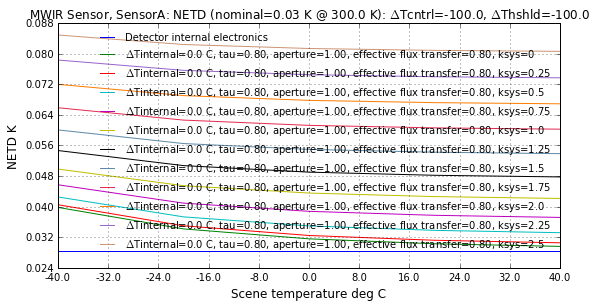

In [15]:
# to plot NETD variations for different values of $k_\textrm{sys}$ (SensorB)
plotNETDAmbient(dfConcept=dfConcept, sensor=u'SensorA', atmotype='gen', atmoSet=['MLS23km'], 
                tempHotShieldDelta=tempHotShieldDeltas[0],
                tempCentralObsDelta=tempCentralObsDeltas[0],tempInsideUnique=[tempInsideUniqueC[1]],
                tempDynamicDelta=tempDynamicUniqueC[0], pathlen=pathlenUniqueGen[0], 
                optFilter=optFilters[0],netdstd=netdstd,
                ksyss=[0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2., 2.25, 2.5],
                wellfill=50, wellcapIdx=0, plotDetail=False)

The following graphs above show the NETD for the standard detector cold filter and:   

1. The three different infrared sensors.
2. Three different internal temperature deltas around ambient outside temperature (0, 20, 40) deg C.
3. Different outside scene temperatures of -10 C to +40 C.
4. The central obscuration and hot shield are assumed to reflect radiance at 100 K below the sensor internal temperature.

The calculation includes all transmittance effects, obscuration effects, hot optics, and cold central obscuration and cold hot shield radiance.  These values are therefore representative of the expected NETD under the stated conditions.

The NETD for SensrorB with different internal temperature deltas are shown next.  As the sensor heats up the hot optics increases the NETD.  For each internal temperature delta two values for system noise are shown: (1) zero system noise and (2) 26 mK system noise.  It is evident that the hot optics and hot scene increases the NETD substantially.

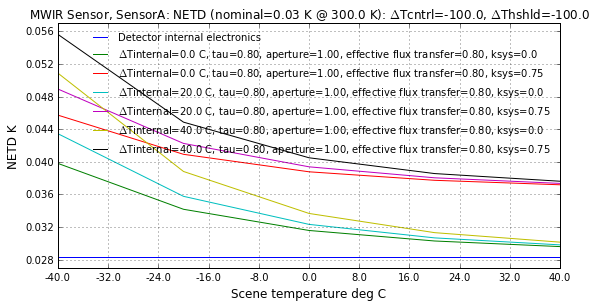

In [16]:
# to plot the NETD variation for sensorA
plotNETDAmbient(dfConcept=dfConcept, sensor=u'SensorA', atmotype='gen', atmoSet=['MLS23km'], 
                tempHotShieldDelta=tempHotShieldDeltas[0],
                tempCentralObsDelta=tempCentralObsDeltas[0],tempInsideUnique=tempInsideUniqueC[1:],
                tempDynamicDelta=tempDynamicUniqueC[2], pathlen=pathlenUniqueGen[0], 
                optFilter=optFilters[0],netdstd=netdstd,ksyss=ksyss, wellfill=50, wellcapIdx=0,
                plotDetail=False)

In [17]:
# to plot the NETD variation for SensorB
# plotNETDAmbient(dfConcept=dfConcept, sensor=u'SensorB', atmotype='gen', atmoSet=['MLS23km'], 
#                 tempHotShieldDelta=tempHotShieldDeltas[0],
#                 tempCentralObsDelta=tempCentralObsDeltas[0],tempInsideUnique=tempInsideUniqueC[1:],
#                 tempDynamicDelta=tempDynamicUniqueC[2], pathlen=pathlenUniqueGen[0], 
#                 optFilter=optFilters[0],netdstd=netdstd,ksyss=ksyss, wellfill=50, wellcapIdx=0, 
#                 plotDetail=True)

The NETD for sensorA with different internal temperature deltas are shown next.  As the sensor heats up the hot optics increases the NETD.  For each internal temperature delta two values for system noise are shown: (1) zero system noise and (2) 26 mK system noise.  

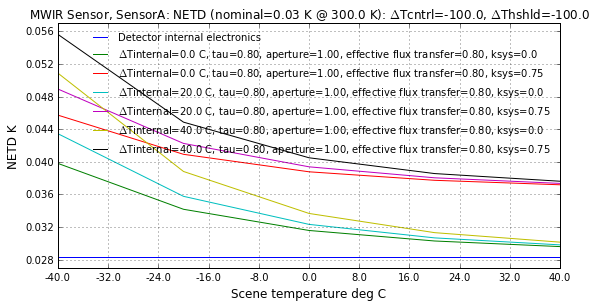

In [18]:
# to plot the NETD variation for sensorA
plotNETDAmbient(dfConcept=dfConcept, sensor=u'SensorA', atmotype='gen', atmoSet=['tropical5km'], 
                tempHotShieldDelta=tempHotShieldDeltas[0],
                tempCentralObsDelta=tempCentralObsDeltas[0],tempInsideUnique=tempInsideUniqueC[1:],
                tempDynamicDelta=tempDynamicUniqueC[2], pathlen=pathlenUniqueGen[0], 
                optFilter=optFilters[0],netdstd=netdstd,ksyss=ksyss, wellfill=50, wellcapIdx=0,
                plotDetail=False)

In [19]:
# to plot the NETD variation for sensorB
# plotNETDAmbient(dfConcept=dfConcept, sensor=u'SensorB', atmotype='gen', atmoSet=['tropical5km'], 
#                 tempHotShieldDelta=tempHotShieldDeltas[0],
#                 tempCentralObsDelta=tempCentralObsDeltas[0],tempInsideUnique=tempInsideUniqueC[1:],
#                 tempDynamicDelta=tempDynamicUniqueC[2], pathlen=pathlenUniqueGen[0], 
#                 optFilter=optFilters[0],netdstd=netdstd,ksyss=ksyss, wellfill=50, wellcapIdx=0,
#                 plotDetail=False)

It is evident that

1. The low optical transmittance degrades the NETD (transmittance of 0.73 increases NETD by 1/0.73=1.4 times).
2. SensorA central obscuration degrades the NETD (clear aperture of 0.7 of total increases NETD by 1/0.7=1.4 times).
3. For SensorA the combined effect of the low transmittance and obscuration is that NETD is doubled, compared to the raw detector NETD).
4. Note that SensorA has a cold reflective element (central obscuration) that decreases the background flux on the detector, slightly lowering the  NETD. This 'lowering' effect is however countered again by the loss in target flux.


## Well-fill Plotting and Analysis 

Given a set of environmental and sensor parameters, this function filters and plots the percentage of well fill versus range for the selected/filtered scenario, and for the selected concept.

In [20]:
# to calculate integration time and well selection
lstContrib = ['EHotOptics [q/(s.m2)]','ECentralObs [q/(s.m2)]','EHotShield [q/(s.m2)]',
              'EPath [q/(s.m2)]','EScene [q/(s.m2)]','EDynamic [q/(s.m2)]',]

bitsCols = ['DataSet','Atmo','AtmoDesc','Sensor','PathLen','TempAmbient [C]','TempInsideDelta [C]',
            'nubitloss','wellfillbitloss','BitsNoFill','wellfillNETD',
            'BitsNETD','BitsAvail', 'TempAmbient [K]',
            'TempHotShield [K]','TempCentralObs [K]',
            'TempIntern [K]','OptFilter','Gain','WellCapacity','IntTime',
            'atmotype','areaDetector','dynamicRangeK','threshold2Noise','netdstd','ksys',
            'TempDynamic [C]','WfHotOptics','WfCentralObs','WfEHotShield','WfPath','WfScene','WfDynamic',
            'WfPhotonStarve','EScene [q/(s.m2)]','EDynamic [q/(s.m2)]',
            'wellfillTargDiff','TargDiffbitsNoNoise','TargDiffbitsNoise','Mderivscn [q/(s.m2.K)]','DeltaTarget'
            ]

def totalE(row):
    total = 0
    for item in lstContrib:
        if item not in 'EScene [q/(s.m2)]':
            total += row[item]
    return pd.Series({'EtotalLocal':total})

def totalEFill(row):
    total = 0
    for item in lstContrib[:-1]:
        if item not in 'EScene [q/(s.m2)]':
            total += row[item]
    return pd.Series({'EtotalLocalFill':total})

def calcIntTimeRange(EtotalLocal, intTime, wellCapacities, areaDetector, quantumEff):
    for wellCapacity in wellCapacities:
        #find well capacity for best well fill
        inttime = wellCapacity / (quantumEff * EtotalLocal * areaDetector)
        if inttime <= intTime:
            break
    inttime = inttime if inttime < intTime else intTime
    return pd.Series({'IntTime':inttime, 'WellCapacity':wellCapacity})


In [21]:
# to plot well fill for different target ranges
def plotPWellFillRange(sensors, dfBitsLoss, dfConcept, atmoSet, tambient, thotshield,  tinternal, 
                       tcentralObs,optFilter, atmotype, intTime,areaDetector, wellCapacity, 
                       dynamicRangeK,ttarget,
                       threshold2Noise,netdstd,ksys,specNETDwellfill = 50, wellcapIdx=0,
                       doPlots=False, ADCbits=14.,iplot=1):
    """This function extracts/filters data from the dataframe, so all parameters must be exact 
    matches to the parameters in the dataframe.
    """

    #we later need this, ensure that it is sorted here
    wellCapacity.sort(reverse=True)
    numAtmo = len(atmoSet)
    
    pathtype = 'Horizontal range' if atmotype=='gen'  else 'Slant range (135-deg zenith)'
    if doPlots:
        p = ryplot.Plotter(iplot,3,numAtmo,figsize=(9*numAtmo,20))
#         print('Input parameters:')
#         print('tambient={}'.format(tambient))
#         print('tinternal={}'.format(tinternal))
#         print('thotshield={}'.format(thotshield))
#         print('tcentralObs={}'.format(tcentralObs))
#         print('dynamicRangeK={}'.format(dynamicRangeK))
#         print('atmoSet={}'.format(atmoSet))
    for i,sensor in enumerate(sensors):
        for j,katmo in enumerate(atmoSet):
            filename = 'data/well-fill/radio-{}-{}-{}.hdf5'.format(Cconcept, sensor, atmotype)
            with pd.HDFStore(filename) as store:
                dfi = store['df{}'.format(sensor)]

                filt = (dfi.Atmo==katmo) & (dfi.Sensor==sensor) & (dfi['TempAmbient [K]']==tambient) & \
                    (np.abs(dfi['TempHotShield [K]']-(tambient+thotshield+tinternal))<0.01) & \
                    (np.abs(dfi['TempCentralObs [K]']-(tambient+tcentralObs+tinternal))<0.01) & \
                    (np.abs(dfi['TempIntern [K]']-(tambient+tinternal))<0.01) & \
                    (dfi['OptFilter']==optFilter)
                if dfi.empty:
                    print('dfi is empty location 1')
                    return
                
                # the integration time and well cap setting is determined for the hottest pixel in the image, 
                # get dynamic range temperature and then calc the integration time and well fill
                # use dfd to handle the dynamic range and calc integration time
                dfd = dfi[filt & (np.abs(dfi['TempDynamic [K]']-(tambient+dynamicRangeK))<0.01)]
                if dfd.empty:
                    print('dfd is empty location 2')
                    return
                
                dfd = dfd.merge(dfd.apply(totalE, axis=1),left_index=True, right_index=True)
                dfd = dfd.merge(dfd.apply(totalEFill, axis=1),left_index=True, right_index=True)
                #here calculate the integration time and well fill for the given total signal photon count  
                if dfd.empty:
                    print('dfd is empty location 3')
                    return
                
                quantumEff = dfConcept[sensor]['quantumEff']

                dfd = dfd.merge(dfd.EtotalLocal.apply(calcIntTimeRange,
                                  args=(intTime, wellCapacity, areaDetector, quantumEff)), 
                          left_index=True, right_index=True)
                if dfd.empty:
                    print('dfd is empty location 4')
                    return
        
                dfd['Gain'] = (100. * quantumEff * areaDetector / dfd['WellCapacity']) * dfd['IntTime']
            
                inttimes = dfd['IntTime'].unique()
                strIntT = '{:.2f} to {:.2f}'.format(1000.*min(inttimes),1000.*max(inttimes)) \
                               if len(inttimes) > 1 else '{:.2f}'.format(1000. * inttimes[0])
                wellcaps = dfd['WellCapacity'].unique()
                strwellC = '{:.1f} to {:.1f}'.format(1e-6*min(wellcaps),1e-6*max(wellcaps)) \
                               if len(wellcaps) > 1 else '{:.2f}'.format(1e-6 * wellcaps[0])  
                
                #build a stack of contributions, but scaling with intTime and WellCap gain for dynamic range
                stack = (dfd[lstContrib[0]] * dfd['Gain']).reshape(1,-1) 
                for item in lstContrib[1:]:
                    stack = np.vstack((stack, (dfd[item] * dfd['Gain']).reshape(1,-1)))
                #what is 'dynamic' in the stack must be dynamic contrast = dynamic - scene
                stack[5,:] = stack[5,:] - stack[4,:]
                    
                #totalWellfill is the total wellfill including the scene dynamic range
                totalWellfill = np.sum(stack.T,axis=1)/100.
                dfd['totalWellfill'] = totalWellfill
                dfd['photstarveloss bits'] = np.where(np.abs(totalWellfill - 1.0) > 0.005,
                                                      np.log(totalWellfill)/np.log(2), 0.)

                df = dfd.copy()
    
                df = df.sort_values(by='PathLen')          
                
                #build a stack of contributions, but scaling with intTime and WellCap gain for hottest pixel
                stack = (df[lstContrib[0]] * df['Gain']).reshape(1,-1) 
                for item in lstContrib[1:]:
                    stack = np.vstack((stack, (df[item] * df['Gain']).reshape(1,-1)))
                #what is 'dynamic' in the stack must be dynamic contrast = dynamic - scene
                stack[5,:] = stack[5,:] - stack[4,:]
                #photon starvation    
                stack = np.vstack((stack,  100. - np.sum(stack,axis=0)))

                
                df['nuloss'] = dfConcept[sensor]['nuloss']
                df['nubitloss'] = np.log(1.0 - df['nuloss'])/np.log(2.)
                #bits lost to optics,  path & scene DC component
                df['EtotalLocalFill'] = df.apply(totalEFill, axis=1)
                df['wellfillbitloss'] = np.log(1.0 - (df['Gain']/100.) * quantumEff * \
                                            (df.EtotalLocalFill+df['EScene [q/(s.m2)]']))/np.log(2.)
                
                df['BitsNoFill'] = ADCbits + df['wellfillbitloss'] + df['nubitloss'] + \
                                                   df['photstarveloss bits']
                
                netdBLIPstd, netdBLIPscene, netdElec, netdSys, netd, nePhiBLIP, nePhiElec, nePhi = \
                                calcNETDScene(df, dfConcept, sensor, specNETDwellfill, wellcapIdx, ksys)
                df['netd'] = netd 
                df['netdBLIPscene'] = netdBLIPscene
                df['netdElec'] = netdElec
                df['netdSys'] = netdSys
                
                df['wellfillNETD'] = threshold2Noise * df['netd'] * (df['Gain']/100.) * df['dEAmbient [q/(s.m2.K)]']
                df['BitsNETD'] =  ADCbits +  np.log(df['wellfillNETD'])/np.log(2.)
                df['BitsAvail'] =  df['BitsNoFill'] - df['BitsNETD']

                # calculate the differential well fill for a small target contrast at scene temperature
                # this is given by 'Mderivscn [q/(s.m2.K)]' * ttarget in units of [q/(s.m2)]
                # multiply with gain to get percentage well fill
                df['wellfillTargDiff'] = df['Mderivscn [q/(s.m2.K)]'] * ttarget * df['Gain']/100
                # convert to bits used from the available bits, BUT IGNORING NOISE
                df['TargDiffbitsNoNoise'] = df['BitsNoFill'] +  np.log(df['wellfillTargDiff'])/np.log(2.)
                # convert to bits used from the available bits, BUT INCLUDING NOISE
                df['TargDiffbitsNoise'] = df['BitsAvail'] +  np.log(df['wellfillTargDiff'])/np.log(2.)
                
                df['threshold2Noise'] = threshold2Noise
                df['netdstd'] = netdstd
                df['ksys'] = ksys
                df['atmotype'] = atmotype
                df['areaDetector'] = areaDetector
                df['dynamicRangeK'] = dynamicRangeK
                            
                # save bits lost data for later use
                df['dataset'] = 'plotPWellFillRange'
                arb = np.hstack((df['dataset'].reshape(-1,1), 
                                 df['Atmo'].reshape(-1,1),
                                 df['AtmoDesc'].reshape(-1,1),
                                 df['Sensor'].reshape(-1,1), 
                                 df['PathLen'].reshape(-1,1),
                                 df['TempAmbient [C]'].reshape(-1,1),
                                 df['TempInsideDelta [C]'].reshape(-1,1),
                                 df['nubitloss'].reshape(-1,1),
                                 df['wellfillbitloss'].reshape(-1,1),
                                 df['BitsNoFill'].reshape(-1,1),
                                 df['wellfillNETD'].reshape(-1,1),                                
                                 df['BitsNETD'].reshape(-1,1),
                                 df['BitsAvail'].reshape(-1,1),
                                 df['TempAmbient [K]'].reshape(-1,1),
                                 df['TempHotShield [K]'].reshape(-1,1),
                                 df['TempCentralObs [K]'].reshape(-1,1),
                                 df['TempIntern [K]'].reshape(-1,1),
                                 df['OptFilter'].reshape(-1,1),
                                 df['Gain'].reshape(-1,1),
                                 df['WellCapacity'].reshape(-1,1),
                                 df['IntTime'].reshape(-1,1),
                                 df['atmotype'].reshape(-1,1),
                                 df['areaDetector'].reshape(-1,1),
                                 df['dynamicRangeK'].reshape(-1,1),
                                 df['threshold2Noise'].reshape(-1,1),
                                 df['netdstd'].reshape(-1,1),
                                 df['ksys'].reshape(-1,1),    
                                 df['TempDynamic [C]'].reshape(-1,1),  
                                 stack.T[:,0].reshape(-1,1),  
                                 stack.T[:,1].reshape(-1,1),  
                                 stack.T[:,2].reshape(-1,1),  
                                 stack.T[:,3].reshape(-1,1),  
                                 stack.T[:,4].reshape(-1,1),  
                                 stack.T[:,5].reshape(-1,1),  
                                 stack.T[:,6].reshape(-1,1),    
                                 df['EScene [q/(s.m2)]'].reshape(-1,1),    
                                 df['EDynamic [q/(s.m2)]'].reshape(-1,1),    
                                 df['wellfillTargDiff'].reshape(-1,1),
                                 df['TargDiffbitsNoNoise'].reshape(-1,1),
                                 df['TargDiffbitsNoise'].reshape(-1,1),
                                 df['Mderivscn [q/(s.m2.K)]'].reshape(-1,1),
                                 ttarget*np.ones(df['Mderivscn [q/(s.m2.K)]'].reshape(-1,1).shape),
                                ))
                
                dfzz = pd.DataFrame(arb, columns=bitsCols)
                dfBitsLoss = dfBitsLoss.append(dfzz,ignore_index=True)

                if doPlots:

                    #get optical transmittance for this run
                    tauOpt = df['Optics Transmittance'].unique()[0] * 100.

                    title = '{}, {}:  {}  Ambient={} C, {}'.format(Cconcept, sensor, katmo, tambient-273., optFilter)
                    label=[x.split()[0][1:] for x in lstContrib]
                    label[0] = '{} {:.1f} C ({:.0f}%)'.format(label[0], tambient+tinternal-273.,tauOpt ) # hot optics in internal
                    label[1] = '{} {:.1f} C'.format(label[1], tambient+tcentralObs+tinternal-273. ) # central obscuration
                    label[2] = '{} {:.1f} C'.format(label[2], tambient+thotshield+tinternal-273. ) # hotshield
                    label[3] = 'Atmospheric {}'.format(label[3].lower()) 
                    label[4] = 'Scene minimum {:.1f} C'.format(tambient-273.) # scene
                    label[5] = 'Dynamic range {:.1f} C'.format(dynamicRangeK) 
                    label.append('Photon starvation')
                    
                    spidx = j+numAtmo*i+1
                    p.stackplot(spidx,df['PathLen'], stack.T, title,'{} [km]'.format(pathtype),'Absolute well fill [%]', 
                                plotCol=['y','c','m','g','r','0.75','w'], label=label,legendLoc='lower right',
                               labelfsize=6,legendAlpha=0.3,pltaxis=[0,np.max(df['PathLen']),0,100])
#                                 plotCol=['y','c','m','b','k','g','r','0.75'], label=label,legendLoc='lower right',

                    p.plot(spidx,df['PathLen'],100.*np.ones((df['PathLen'].shape)),plotCol=['k'])

                    #write dataframe columns to file for debugging
                    if False:
                        with open('test.txt', 'w') as fi:
                            fi.write('{}'.format(list(df.columns.values)))

                    currentP = p.getSubPlot(spidx)
                    maxplot = np.max(np.sum(stack,axis=0))
                    currentP.text(df['PathLen'].as_matrix()[0], 92, r'Dynamic range = {} K'.format(dynamicRangeK), 
                                  horizontalalignment='left', fontsize=10)                
                    currentP.text(df['PathLen'].as_matrix()[0], 82, r'Integration time = {} ms'.format(strIntT), 
                                  horizontalalignment='left', fontsize=10)
                    currentP.text(df['PathLen'].as_matrix()[0], 72, r'Well capacity = {} Me$^-$'.format(strwellC), 
                                  horizontalalignment='left', fontsize=10)                

                    for ii,idx in enumerate(df.index):
                        strTxt = '{:.1f} Me$^-$ {:.2f} ms'.format(1e-6*df['WellCapacity'][idx], 1000.*df['IntTime'][idx])
                        currentP.text(df['PathLen'].as_matrix()[ii], 0.02*maxplot, strTxt, 
                                  horizontalalignment='left', verticalalignment='bottom', fontsize=10, rotation=90)

                    ax2 = currentP.twinx()
                    ax2.plot(df['PathLen'].as_matrix(), df['BitsNoFill'].as_matrix(),'k')
                    ax2.plot(df['PathLen'].as_matrix(), df['BitsNETD'].as_matrix(),'k',linestyle='-.')
                    ax2.plot(df['PathLen'].as_matrix(), df['BitsAvail'].as_matrix(),'k',linestyle='--')
                    ax2.set_ylabel('Bits in target range', color='k')
                    ax2.set_ylim(0, ADCbits)
                    
                    
    #try to force some garbage collection       
    dfi = None
    dfd = None
    df = None
    df = None
    dfzz = None
    n = gc.collect()
#     print('Unreachable objects: {}'.format(n))
#     print('Remaining Garbage: {}'.format(gc.garbage))

    return dfBitsLoss


In [22]:
dfBitsLoss = pd.DataFrame(columns=bitsCols)

In [23]:
# to plot well fill for different target temperature contrast values

lstContribContrast = ['EHotOptics [q/(s.m2)]','ECentralObs [q/(s.m2)]','EHotShield [q/(s.m2)]',
              'EPath [q/(s.m2)]','EScene [q/(s.m2)]','EDynamic [q/(s.m2)]',]

def totalEContrast(row):
    total = 0
    for item in lstContribContrast:
        if item not in 'EScene [q/(s.m2)]':
            total += row[item]
    return pd.Series({'EtotalLocal':total})

def totalEFillContrast(row):
    total = 0
    for item in lstContribContrast[0:5]:
        total += row[item]
    return pd.Series({'EtotalLocalFill':total})

def plotPWellFillTargetContrast(sensors,dfBitsLoss, dfConcept, atmoSet, tambient, thotshield,  
                                tinternal,  tcentralObs, trange, optFilter, atmotype, 
                                intTime,areaDetector, wellCapacity, dynamicRangeK,ttarget,
                                threshold2Noise,netdstd,ksys,specNETDwellfill=50, wellcapIdx=0,
                                doPlots=False, ADCbits=14,iplot=1):
    """This function extracts/filters data from the dataframe, so all parameters must be exact 
    matches to the parameters in the dataframe.
    """
    
    #we later need this, ensure that it is sorted here
    wellCapacity.sort(reverse=True)
    numAtmo = len(atmoSet)
    if doPlots:
        p = ryplot.Plotter(iplot,3,numAtmo,figsize=(9*numAtmo,20));
#         print('Input parameters:')
#         print('tambient={}'.format(tambient))
#         print('tinternal={}'.format(tinternal))
# #         print('ttarget={}'.format(ttarget))
#         print('thotshield={}'.format(thotshield))
#         print('tcentralObs={}'.format(tcentralObs))
#         print('dynamicRangeK={}'.format(dynamicRangeK))
#         print('atmoSet={}'.format(atmoSet))
    for i,sensor in enumerate(sensors):
        for j,katmo in enumerate(atmoSet):
            filename = 'data/well-fill/radio-{}-{}-{}.hdf5'.format(Cconcept, sensor, atmotype)
            with pd.HDFStore(filename) as store:
                dfi = store['df{}'.format(sensor)]
                
                filt = (dfi.Atmo==katmo) & (dfi.Sensor==sensor) & (dfi['TempAmbient [K]']==tambient) & \
                    (np.abs(dfi['TempHotShield [K]']-(tambient+thotshield+tinternal))<0.01) & \
                    (np.abs(dfi['TempCentralObs [K]']-(tambient+tcentralObs+tinternal))<0.01) & \
                    (np.abs(dfi['TempIntern [K]']-(tambient+tinternal))<0.01) & \
                    (np.abs(dfi['PathLen']-trange)<0.001) & \
                    (dfi['OptFilter']==optFilter) & \
                    (dfi['TempDynamic [K]'] <= tambient + dynamicRangeK )
                if dfi.empty:
                    print('dfi is empty location 1')
                    return
                   
                #the integration time and well cap setting is determined for the hottest pixel in the image
                #which normally is not the target pixel. Calc for hottest pixel independently
                #get dynamic range target only and then calc the integration time and well fill for max target
                dfd = dfi[filt] #& (np.abs(dfi['TempTarget [K]']-(tambient+dynamicRangeK))<0.01)
                if dfd.empty:
                    print('dfd is empty location 2')
                    print(tambient+dynamicRangeK)
                    print('vs')
                    print(dfi['TempDynamic [K]'].unique())
                    return
                 
                #after the following EtotalLocalFill will have irradiance from nonscene sources
                dfd = dfd.merge(dfd.apply(totalEFillContrast, axis=1),left_index=True, right_index=True)
                #after the following EtotalLocal will have irradiance from nonscene + scene sources
                dfd = dfd.merge(dfd.apply(totalEContrast, axis=1),left_index=True, right_index=True)
                if dfd.empty:
                    print('dfd is empty location 3')
                    return
                    
                #here calculate the integration time and well fill for the given max signal photon count
                #after this 'IntTime' will have the integration time and 'WellCapacity' ditto
                quantumEff = dfConcept[sensor]['quantumEff']
                dfd = dfd.merge(dfd.EtotalLocal.apply(calcIntTimeRange,
                              args=(intTime, wellCapacity, areaDetector,quantumEff)), 
                          left_index=True, right_index=True)
                # now find one value for well & integration at max temperature, use for all samples
                maxTrow = dfd[dfd['TempDynamic [K]']==np.max(dfd['TempDynamic [K]'])]
                dfd['IntTime'] = maxTrow['IntTime'].values * np.ones(dfd['IntTime'].shape)
                dfd['WellCapacity'] = maxTrow['WellCapacity'].values * np.ones(dfd['WellCapacity'].shape)
                if dfd.empty:
                    print('dfd is empty location 4')
                    return
                
                dfd = dfd.sort_values(by='TempDynamic [K]')
                localtempDynamicDeltas = dfd['TempDynamic [C]'].values
                
                dfd['Gain'] = (100. * quantumEff * areaDetector / dfd['WellCapacity']) * dfd['IntTime']
                inttimes = dfd['IntTime'].unique()
                strIntT = '{:.2f} to {:.2f}'.format(1000.*min(inttimes),1000.*max(inttimes)) \
                               if len(inttimes) > 1 else '{:.2f}'.format(1000. * inttimes[0])
                wellcaps = dfd['WellCapacity'].unique()
                strwellC = '{:.1f} to {:.1f}'.format(1e-6*min(wellcaps),1e-6*max(wellcaps)) \
                               if len(wellcaps) > 1 else '{:.2f}'.format(1e-6 * wellcaps[0])  
                
                df = dfi[filt].copy()
                df['Gain'] = dfd['Gain'].values[0]

                df['WellCapacity'] = wellcaps[0]
                df['IntTime'] = inttimes[0]
                df['atmotype'] = atmotype
                df['areaDetector'] = areaDetector
                df['dynamicRangeK'] = dynamicRangeK
                 
                #get optical transmittance for this run
                tauOpt = df['Optics Transmittance'].unique()[0] * 100.

                #build a stack of contributions, but scaling with intTime and WellCap gain for hottest pixel
                stack = (df[lstContribContrast[0]] * df['Gain']).reshape(1,-1) 
                for item in lstContribContrast[1:]:
                    stack = np.vstack((stack, (df[item] * df['Gain']).reshape(1,-1)))
                #what is 'dynamic' in the stack must be dynamic contrast = dynamic - scene
                stack[5,:] = stack[5,:] - stack[4,:]
                # unused dynamic range 
                stack = np.vstack((stack, np.max(stack[5,:]) - stack[5,:]))
                #placeholder for photon starvation
                stack = np.vstack((stack, np.zeros(stack[5,:].shape)))
                

                #totalWellfill is the  wellfill including dynamic range
                totalWellfill = np.max(np.sum(stack[0:6,:].T,axis=1)/100.)
                
                df['totalWellfill'] = totalWellfill
                df['photstarveloss bits'] = np.where(np.abs(totalWellfill - 1.0) > 0.005,
                                                      np.log(totalWellfill)/np.log(2), 0.)
                df['nubitloss'] = np.log(1.0 - dfConcept[sensor]['nuloss'])/np.log(2.)
                df['nuloss'] = dfConcept[sensor]['nuloss']
                df['Bitsunused'] = np.zeros(df['nuloss'].shape)
#                 df['Bitsunused'] = -ADCbits*np.log(np.max(stack[6,:]/100))/np.log(2) - \
#                                     np.where(stack[6,:]>0,np.log(stack[6,:]/100)/(np.log(2)),0)
#                 df['Bitsunused'] -= np.max(df['Bitsunused'])  
#                 df['Bitsunused'] = np.log((stack[6,:]/np.max(stack[6,:]))/np.log(2))
                
    
                #bits lost to optics,  path & scene DC component
                df['EtotalLocalFill'] = df.apply(totalEFillContrast, axis=1)
                df['wellfillbitloss'] = np.log(1.0 - (df['Gain']/100.) * quantumEff * \
                                            (df.EtotalLocalFill+df['EScene [q/(s.m2)]']))/np.log(2.)
                df['BitsNoFill'] = ADCbits + df['wellfillbitloss'] + df['nubitloss'] + \
                                                   df['photstarveloss bits']

                    
                    
                    
                # additional bits lost to the small target compared to dynamic range
                df['UnusedNorm'] = (stack[5,:]-np.min(stack[5,:]))/(np.max(stack[5,:])-np.min(stack[5,:]))
                df['BitlostDyn'] =  np.log(df['UnusedNorm'])/np.log(2)
                df['BitsNoFill'] += df['BitlostDyn']
              
                netdBLIPstd, netdBLIPscene, netdElec, netdSys, netd, nePhiBLIP, nePhiElec, nePhi = \
                    calcNETDScene(df, dfConcept, sensor, specNETDwellfill, wellcapIdx, ksys)
                df['netd'] = netd 
                df['netdBLIPscene'] = netdBLIPscene
                df['netdElec'] = netdElec
                df['netdSys'] = netdSys
                df['threshold2Noise'] = threshold2Noise
                df['netdstd'] = netdstd
                df['ksys'] = ksys
                
                df['wellfillNETD'] = threshold2Noise * df['netd'] * df['Gain'] * df['dEAmbient [q/(s.m2.K)]']
                df['BitsNETD'] =  ADCbits +  np.log(df['wellfillNETD']/100.)/np.log(2.)
                
                df['BitsAvail'] =  df['BitsNoFill'] - df['BitsNETD']

                # calculate the differential well fill for a small target contrast at scene temperature
                # this is given by 'Mderivscn [q/(s.m2.K)]' * ttarget in units of [q/(s.m2)]
                # multiply with gain to get percentage well fill
                df['wellfillTargDiff'] = df['Mderivscn [q/(s.m2.K)]'] * ttarget * df['Gain']/100
                # convert to bits used from the available bits, BUT IGNORING NOISE
                df['TargDiffbitsNoNoise'] = df['BitsNoFill'] +  np.log(df['wellfillTargDiff'])/np.log(2.)
                # convert to bits used from the available bits, BUT INCLUDING NOISE
                df['TargDiffbitsNoise'] = df['BitsAvail'] +  np.log(df['wellfillTargDiff'])/np.log(2.)
                    
                
                
#                 print(df[['UnusedNorm','BitlostDyn','wellfillbitloss','totalWellfill','photstarveloss bits','BitsNoFill','BitsAvail']])
                
                
                # save bits lost data for later use
                df['dataset'] = 'plotPWellFillTargetContrast'
                arb = np.hstack((df['dataset'].reshape(-1,1),
                                 df['Atmo'].reshape(-1,1),
                                 df['AtmoDesc'].reshape(-1,1),
                                 df['Sensor'].reshape(-1,1), 
                                 df['PathLen'].reshape(-1,1),
                                 df['TempAmbient [C]'].reshape(-1,1),
                                 df['TempInsideDelta [C]'].reshape(-1,1),
                                 df['nubitloss'].reshape(-1,1),
                                 df['wellfillbitloss'].reshape(-1,1),
                                 df['BitsNoFill'].reshape(-1,1),
                                 df['wellfillNETD'].reshape(-1,1),                                
                                 df['BitsNETD'].reshape(-1,1),
                                 df['BitsAvail'].reshape(-1,1),
                                 df['TempAmbient [K]'].reshape(-1,1),
                                 df['TempHotShield [K]'].reshape(-1,1),
                                 df['TempCentralObs [K]'].reshape(-1,1),
                                 df['TempIntern [K]'].reshape(-1,1),
                                 df['OptFilter'].reshape(-1,1),
                                 df['Gain'].reshape(-1,1),
                                 df['WellCapacity'].reshape(-1,1),
                                 df['IntTime'].reshape(-1,1),
                                 df['atmotype'].reshape(-1,1),
                                 df['areaDetector'].reshape(-1,1),
                                 df['dynamicRangeK'].reshape(-1,1),
                                 df['threshold2Noise'].reshape(-1,1),
                                 df['netdstd'].reshape(-1,1),
                                 df['ksys'].reshape(-1,1),  
                                 df['TempDynamic [C]'].reshape(-1,1),  
                                 stack.T[:,0].reshape(-1,1),  
                                 stack.T[:,1].reshape(-1,1),  
                                 stack.T[:,2].reshape(-1,1),  
                                 stack.T[:,3].reshape(-1,1),  
                                 stack.T[:,4].reshape(-1,1),  
                                 stack.T[:,5].reshape(-1,1),  
                                 stack.T[:,6].reshape(-1,1),      
                                 df['EScene [q/(s.m2)]'].reshape(-1,1),    
                                 df['EDynamic [q/(s.m2)]'].reshape(-1,1),
                                 df['wellfillTargDiff'].reshape(-1,1),
                                 df['TargDiffbitsNoNoise'].reshape(-1,1),
                                 df['TargDiffbitsNoise'].reshape(-1,1),
                                 df['Mderivscn [q/(s.m2.K)]'].reshape(-1,1),
                                 ttarget*np.ones(df['Mderivscn [q/(s.m2.K)]'].reshape(-1,1).shape),
                                
                                ))
               
                dfzz = pd.DataFrame(arb, columns=bitsCols)
                dfBitsLoss = dfBitsLoss.append(dfzz,ignore_index=True)

                if doPlots:
                
                    title = '{}, {}: {}, {:.0f} km, Amb={} C, {}'.format(Cconcept, sensor, katmo, trange, tambient-273.,optFilter)
                    label=[x.split()[0][1:] for x in lstContribContrast]
                    label[0] = '{} {:.1f} C ({:.0f}%)'.format(label[0], tambient+tinternal-273.,tauOpt ) # hot optics in internal
                    label[1] = '{} {:.1f} C'.format(label[1], tambient+tcentralObs+tinternal-273. ) # central obscuration
                    label[2] = '{} {:.1f} C'.format(label[2], tambient+thotshield+tinternal-273. ) # hotshield
                    label[3] = 'Atmospheric {}'.format(label[3].lower()) 
                    label[4] = 'Scene minimum {:.1f} C'.format(tambient-273.) # scene
                    label[5] = 'Target signal' # target
                    label.append('Unused dynamic range' )
                    label.append('Photon starvation' )


                    spidx = j+numAtmo*i+1
                    plotCol=['y','c','m','g','r','0.75','.9','w']
                    
                    p.stackplot(spidx,localtempDynamicDeltas, stack.T, title,'Target temperature [K]',
                                'Absolute well fill [%]', 
                                plotCol=plotCol, label=label,legendLoc='lower right',
                                legendAlpha=0.5,pltaxis=[np.min(localtempDynamicDeltas),np.max(localtempDynamicDeltas),0, 100.])

                    p.plot(spidx,localtempDynamicDeltas,100.*np.ones((localtempDynamicDeltas.shape)),plotCol=['k'])

                    currentP = p.getSubPlot(spidx)
                    maxplot = np.max(np.sum(stack,axis=0))
                    currentP.text(localtempDynamicDeltas[0], 92, r'Dynamic range = {} K'.format(dynamicRangeK), 
                                  horizontalalignment='left', fontsize=10)                
                    currentP.text(localtempDynamicDeltas[0], 82, r'Integration time = {} ms'.format(strIntT), 
                                  horizontalalignment='left', fontsize=10)
                    currentP.text(localtempDynamicDeltas[0], 72, r'Well capacity = {} Me$^-$'.format(strwellC),
                                  horizontalalignment='left', fontsize=10)

                    ax2 = currentP.twinx()
    #                 ax2.plot(localtempDynamicDeltas, 6+5*df['wellfillbitloss'].as_matrix(),'b')
    #                 ax2.plot(localtempDynamicDeltas, 4+df['nubitloss'].as_matrix(),'r')
                    ax2.plot(localtempDynamicDeltas, df['BitsNoFill'].as_matrix(),'k')
                    ax2.plot(localtempDynamicDeltas, df['BitsNETD'].as_matrix(),'k',linestyle='-.')
                    ax2.plot(localtempDynamicDeltas, df['BitsAvail'].as_matrix(),'k',linestyle='--')
                    ax2.set_ylabel('Bits in target range', color='k')
                    ax2.set_ylim(0, ADCbits)

    #try to force some garbage collection       
    dfi = None
    dfd = None
    df = None
    dfzz = None
    n = gc.collect()
#     print('Unreachable objects: {}'.format(n))
#     print('Remaining Garbage: {}'.format(gc.garbage))
                
    return dfBitsLoss
                


In [24]:
# to display selected results in tabular format
def tableDatasets(sensors, dfConcept, atmoSet, tambient, thotshield,  tinternal, tcentralObs, 
                  ttarget, optFilter, trange, atmotype):
    """This function extracts/filters data from the dataframe, so all temperatures must be exact 
    matches to the temperatures in the dataframe.
    """
    sumcols = ['Atmo','PathLen', 'Sensor','OptFilter','TempAmbient [C]','TempIntern [C]','TempDynamic [C]',
                        'EInternal [%Tar]','EPath [%Tar]','EDynamic [%Tar]',]
    dfr = pd.DataFrame(columns=sumcols)
    for i,sensor in enumerate(sensors):
        for j,katmo in enumerate(atmoSet):
            with pd.HDFStore('data/well-fill/radio-{}-{}-{}.hdf5'.format(Cconcept, sensor,atmotype)) as store:
                df = store['df{}'.format(sensor)]
#                 print(df.columns)
                filt = (df.Atmo==katmo) & (df.Sensor==sensor) & (df['TempAmbient [K]']==tambient) & \
                    (df['TempHotShield [K]']==tambient+thotshield+tinternal) & (df['TempCentralObs [K]']==tambient+tcentralObs+tinternal) & \
                    (df['TempIntern [K]']==tambient+tinternal) & (df['TempDynamic [K]']==tambient+ttarget) & \
                    (df['PathLen']==trange) 
                df = df[filt]
                df = df[sumcols]
                dfr = dfr.append(df)
    return dfr

def printDataset(df):
    print('Ambient temperature  {} C'.format(df['TempAmbient [C]'].unique()[0]))
    print('Internal temperature {} C'.format(df['TempIntern [C]'].unique()[0]))
    print('Target delta temperature   {} C'.format(df['TempDynamic [C]'].unique()[0]-df['TempAmbient [C]'].unique()[0]))
    df = df.drop(['TempDynamic [C]', 'TempIntern [C]', 'TempAmbient [C]'],axis=1)
    print(df)
    print(' ')
    
# to plot the results in tabular format for a very hot scene and internal temperatures at 10 km
tambient = tempAmbUnique[3]
tinternal = tempInternDeltas[2]
ttarget = TempTargetDeltaC
thotshield = tempHotShieldDeltas[0]
tcentralObs = tempCentralObsDeltas[0]
trange = pathlenUniqueGen[-1]
optFilter=optFilters[0]

# only do for SensorA
sensors = [dfConcept.columns.values[0]]
# dfr=tableDatasets(dfConcept=dfConcept, atmoSet=['MLS23km','tropical5km','SW31km'], tambient=tambient, 
dfr=tableDatasets(sensors=sensors,dfConcept=dfConcept, atmoSet=['tropical5km'], tambient=tambient, 
                  thotshield=thotshield,tinternal=tinternal,tcentralObs=tcentralObs,
                  ttarget=ttarget, optFilter=optFilter, trange=trange,atmotype='gen')
printDataset(dfr)    

Ambient temperature  20.0 C
Internal temperature 40.0 C
Target delta temperature   2.0 C
              Atmo  PathLen   Sensor OptFilter  EInternal [%Tar]  EPath [%Tar]  EDynamic [%Tar]
19801  tropical5km     10.0  SensorA  Standard         33.511474     62.866403         3.622123
48841  tropical5km     10.0  SensorA     Notch         33.411121     61.919982         4.668897
 


# Results

## Generic Atmospheres Well Fill vs Range

The graphs given in this section shows the percentage of well fill for the various contributors to the total number of electrons in the well, as a function of range.  It is clearly evident that the atmospheric transmittance and path radiance has a huge effect on the percentages as a function of range.   Particularly, what appears as a reasonable large percentage at short range diminishes to sub=10% values at longer ranges.

The relevant temperatures are stated in each graph in order to assist in interpretation of the results.

In [25]:
# to determine the unique values in the database for the generic atmosperes
def loadGenericAtmodata():
    # The data file is analysed to extract the sets of unique values for subsequent filtering and plotting.
    sensor = dfConcept.columns.values[0]
    with pd.HDFStore('data/well-fill/radio-{}-{}-{}.hdf5'.format(Cconcept,sensor,'gen')) as store:
        df = store['df{}'.format(sensor)]
        atmoUnique = df['Atmo'].unique()
        sensorUnique = sensors
        tempAmbUnique = df['TempAmbient [K]'].unique()
        tempAmbUniqueC = df['TempAmbient [C]'].unique()
        tempSceneUniqueC = df['TempScene [C]'].unique()
        tempInsideUniqueC = df['TempInsideDelta [C]'].unique()
        tempCentralUniqueC = df['TempCentralObsDelta [C]'].unique()
        tempHotAmbUniqueC = df['TempHotShieldDelta [C]'].unique()
        tempInternUnique = df['TempIntern [K]'].unique()
        tempDynamicUnique = df['TempDynamic [K]'].unique()
        pathlenUniqueGen = df['PathLen'].unique()
        tempDynamicUniqueC = df['TempDynamic [C]'].unique()

        print('Values available in the HDF5 file')
        print('atmoUnique: {}'.format(atmoUnique))
        print('sensorUnique: {}'.format(sensorUnique))
        print('tempAmbUnique: {}'.format(tempAmbUnique))   
        print('tempInternUnique: {}'.format(tempInternUnique))   
        print('tempDynamicUnique: {}'.format(tempDynamicUnique))   
        print('tempInternDeltas: TempAmbient + {}'.format(tempInternDeltas))
        print('tempDynamicDeltas: TempAmbient + {}'.format(tempDynamicDeltas))
        print('pathlenUniqueGen: {}'.format(pathlenUniqueGen))
        print('tempCentralObsDeltas: TempAmbient + {}'.format(tempCentralObsDeltas))
        print('tempHotShieldDeltas: TempAmbient + {}'.format(tempHotShieldDeltas))
        print('TempAmbient [C]: {}'.format(tempAmbUniqueC))
        print('TempScene [C]:  {}'.format(tempSceneUniqueC))
        print('TempInsideDelta [C]:  {}'.format(tempInsideUniqueC))
        print('TempCentralObsDelta [C]:  {}'.format(tempCentralUniqueC))
        print('TempHotShieldDelta [C]:  {}'.format(tempHotAmbUniqueC))
        print('TempDynamicDelta [C]:  {}'.format(tempDynamicUniqueC))
        
        
loadGenericAtmodata()

Values available in the HDF5 file
atmoUnique: ['MLS23km' 'tropical5km' 'SW31km']
sensorUnique: [u'SensorA']
tempAmbUnique: [ 233.  253.  273.  293.  313.]
tempInternUnique: [ 133.  153.  173.  193.  213.  233.  253.  273.  293.  313.  333.  353.]
tempDynamicUnique: [ 233.  235.  238.  243.  253.  263.  273.  283.  293.  303.  313.  255.
  258.  323.  333.  275.  278.  343.  353.  295.  298.  363.  373.  315.
  318.  383.  393.]
tempInternDeltas: TempAmbient + [-100, 0, 20, 40]
tempDynamicDeltas: TempAmbient + [0.0, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0]
pathlenUniqueGen: [  1.00000000e-03   1.00090000e+00   2.00080000e+00   3.00070000e+00
   4.00060000e+00   5.00050000e+00   6.00040000e+00   7.00030000e+00
   8.00020000e+00   9.00010000e+00   1.00000000e+01]
tempCentralObsDeltas: TempAmbient + [-100.0, 0]
tempHotShieldDeltas: TempAmbient + [-100.0, 0.0]
TempAmbient [C]: [-40. -20.   0.  20.  40.]
TempScene [C]:  [-40. -20.   0.  20.  40.]
TempInsideDelta [C]:  [-100.

### Perfect optics
The following graph shows the situation for perfectly transmitting and cold optics: there is no flux from any sensor component onto the detector.  It is clear that even for perfect sensors the path radiance has a huge well fill contribution and the 2 K contrast target contribution approaches very low well-fill values at long range.

Note that the noise consumes four bits and about three bits (SensorA).
After losing bits to well fill and noise, the usable 40 K dynamic range image has between 7 and 9 bits (SensorA and SensorB) and 11 bits (SensorA).

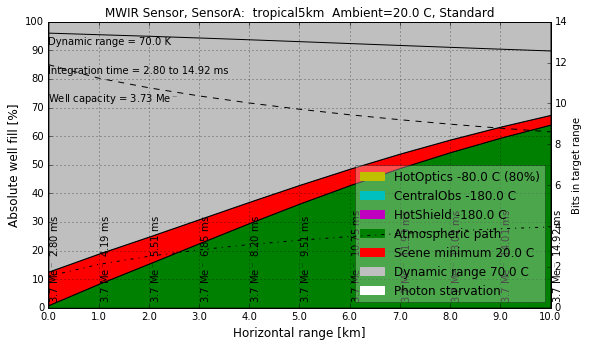

In [26]:
# to plot the well fill for perfect optics
tambient = tempAmbUnique[3]
tinternal = tempInternDeltas[0]
ttarget = TempTargetDeltaC
thotshield = tempHotShieldDeltas[0]
tcentralObs = tempCentralObsDeltas[0]
dynamicRangeK = tempDynamicDeltas[9] #TempDynamicPlot
# only do for SensorA
sensors = [dfConcept.columns.values[0]]

# dfBitsLoss = plotPWellFillRange(dfBitsLoss=dfBitsLoss, dfConcept=dfConcept, atmoSet=['MLS23km','tropical5km'], 
dfBitsLoss = plotPWellFillRange(sensors=sensors,dfBitsLoss=dfBitsLoss, dfConcept=dfConcept, atmoSet=['tropical5km'], 
                                tambient=tambient, thotshield=thotshield,tinternal=tinternal,
                                tcentralObs=tcentralObs, 
                                optFilter=optFilters[0], atmotype='gen', intTime=integrationTime, 
                                areaDetector=areaDetector,wellCapacity=wellCapacityUsable, 
                                dynamicRangeK=dynamicRangeK,ttarget=ttarget,threshold2Noise=threshold2Noise,
                                netdstd=netdstd,ksys=ksyss[-1],doPlots=True)


### Worst performance optics

The worst case is for sensors where all obstructions are hot and the sensor and ambient conditions result in high internal temperatures. The following graph shows the situation for hot optics and hot obstructions. Note that the central obscuration are all at internal sensor temperatures, i.e., no cold reflections.

The contribution of the warm central obscuration  in SensorA is quite large: these components have to be cooled or reflect the cold detector.  Even in the case of the near-optimal SensorB, the hot optics and path radiance contributions are huge.  


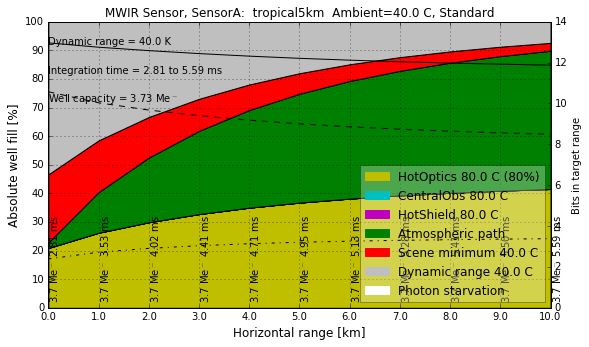

In [27]:
# to plot the well fill for the worse optics
tambient = tempAmbUnique[4]
tinternal = tempInternDeltas[3]
ttarget = TempTargetDeltaC
thotshield = tempHotShieldDeltas[1]
tcentralObs = tempCentralObsDeltas[1]
dynamicRangeK = TempDynamicPlot
# only do for SensorA
sensors = [dfConcept.columns.values[0]]

# dfBitsLoss = plotPWellFillRange(dfBitsLoss=dfBitsLoss, dfConcept=dfConcept, atmoSet=['MLS23km','tropical5km'], tambient=tambient, thotshield=thotshield,tinternal=tinternal,
dfBitsLoss = plotPWellFillRange(sensors=sensors,dfBitsLoss=dfBitsLoss, dfConcept=dfConcept, 
            atmoSet=['tropical5km'], tambient=tambient, thotshield=thotshield,tinternal=tinternal,
             tcentralObs=tcentralObs, optFilter=optFilters[0],
            atmotype='gen', intTime=integrationTime, areaDetector=areaDetector,wellCapacity=wellCapacityUsable, 
                   dynamicRangeK=dynamicRangeK,ttarget=ttarget,threshold2Noise=threshold2Noise,netdstd=netdstd,ksys=ksyss[-1],doPlots=True)

### Well fill as function of target range


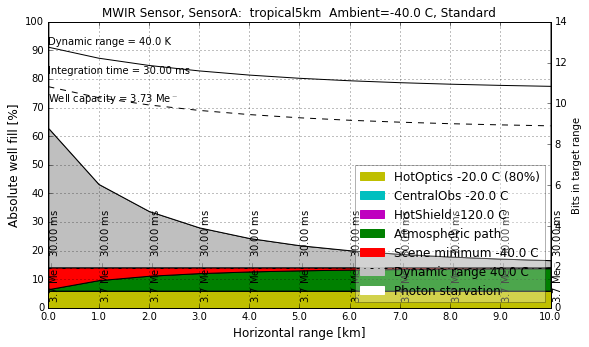

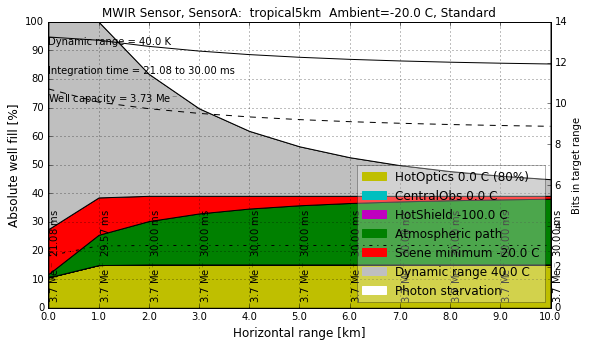

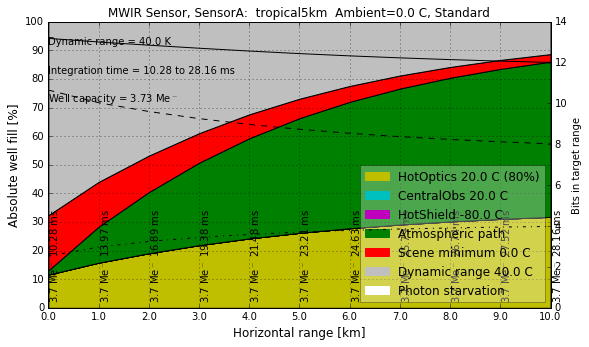

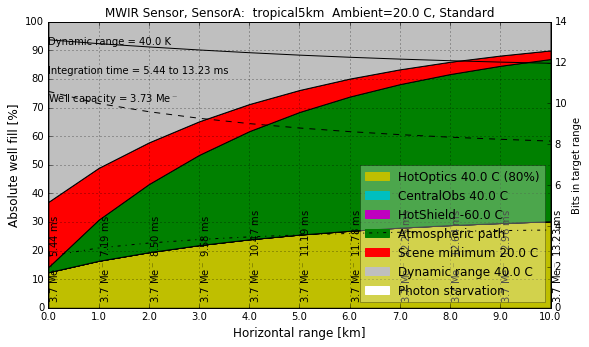

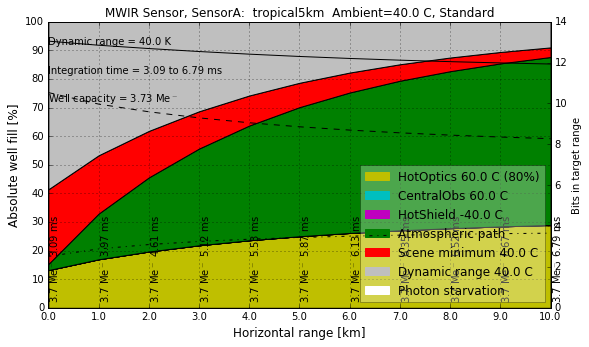

In [28]:
# to calculate and plot the results
# only do for SensorA
sensors = [dfConcept.columns.values[0]]


iplot=1
for tinternal in [2]:
    for ttarget in [TempTargetDeltaC]:
        for thotshield in [0]:
            for tcentralObs in [1]:
                for dynamicRangeK in [indexTempDynamicPlot]:
                    for atmo in ['tropical5km','MLS23km','SW31km']:
                        for tambient in [0,1,2,3,4]:
                            doPlots = True if atmo in 'tropical5km' else False
                            iplot += 1
                            dfBitsLoss = plotPWellFillRange(sensors=sensors,
                                            dfBitsLoss=dfBitsLoss, 
                                            dfConcept=dfConcept, atmoSet=[atmo], 
                                            tambient=tempAmbUnique[tambient],
                                            thotshield=tempHotShieldDeltas[thotshield],
                                            tinternal=tempInternDeltas[tinternal], 
                                            tcentralObs=tempCentralObsDeltas[tcentralObs],
                                            optFilter=optFilters[0],
                                            atmotype='gen', intTime=integrationTime, 
                                            areaDetector=areaDetector,
                                            wellCapacity=wellCapacityUsable, 
                                            dynamicRangeK=tempDynamicDeltas[dynamicRangeK],
                                            ttarget=ttarget,
                                            threshold2Noise=threshold2Noise,
                                            netdstd=netdstd,ksys=ksyss[-1],
                                            doPlots=doPlots,iplot=iplot)                            
    

In [29]:
# to calculate the number of bits lost
def tableBitsLoss(dfBitsLoss, atmoSet, sensorSet, 
                 tranges, tambients,
                thotshield, tcentralObs, tinternal,
                optFilter,ttarget,atmotype,tdynamic):

    """This function extracts/filters data from the dfBitsLoss dataframe
    """
    sumcols = ['Atmo','PathLen', 'Sensor','OptFilter','TempAmbient [C]','TempAmbient [K]','IntTime',
               'BitsAvail','BitsNoFill','BitsNETD','DeltaTarget',
               'WfHotOptics', 'WfCentralObs', 'WfEHotShield',
               'WfPath', 'WfScene','WfDynamic', 'WfPhotonStarve','wellfillTargDiff',
               'Mderivscn [q/(s.m2.K)]','EDynamic [q/(s.m2)]','EScene [q/(s.m2)]',
               'TargDiffbitsNoNoise','TargDiffbitsNoise'
                        ]
    
    
    for i,sensor in enumerate(sensorSet):
        for j,katmo in enumerate(atmoSet):
            
            print('{}'.format(80*'*'))
            print('{}'.format(80*'*'))
            print('{}'.format(80*'*'))
                    
            print('Sensor                         : {} '.format(sensor))
            print('Atmosphere                     : {} '.format(katmo))
            print('Sensor dynamic range           : {} C'.format(tdynamic))
            print('Hot shield temperature         : {} C'.format(thotshield+tinternal))
            print('Central obsuration temperature : {} C'.format(tcentralObs+tinternal))
            print('Internal temperature           : {} C'.format(tinternal))
            print('Filter                         : {} '.format(optFilter))

            dfr = pd.DataFrame(columns=sumcols)
           
            for r,trange in enumerate(tranges):
                for t,tambient in enumerate(tambients):
                    df = dfBitsLoss.copy()
                    filt = (df.Atmo==katmo) & \
                        (df.Sensor==sensor) & \
                        (df['PathLen']==trange) & \
                        (np.abs(df['TempAmbient [K]']-(tambient))<1.) & \
                        (np.abs(df['TempHotShield [K]']-(tambient+thotshield+tinternal))<1.)  & \
                        (np.abs(df['TempCentralObs [K]']-(tambient+tcentralObs+tinternal))<1.)  & \
                        (np.abs(df['TempIntern [K]']-(tambient+tinternal))<1.)  & \
                        (np.abs(df['DeltaTarget']-(ttarget))<1.)
                    df = df[filt]
                    df = df[sumcols]
                    dfr = dfr.append(df)
                    
            dfr['IntTime'] *= 1000.
            dfr['WfSceneDyn'] = dfr['WfScene'] + dfr['WfDynamic']

            dfr = dfr.drop(['Sensor','OptFilter','WfHotOptics','WfCentralObs','WfEHotShield','WfPath',
                            'WfPhotonStarve','TempAmbient [K]'],axis=1)

            print('\n{}'.format(80*'*'))

            print('Stare time vs. scene temperature')
            dfp = pd.pivot_table(dfr, values='IntTime', 
                                  index=['TempAmbient [C]'], 
                                  columns=['PathLen'],aggfunc = lambda x: np.mean(x))
            print(dfp.round(1))

            print('\n{}'.format(80*'*'))
            print('Available well fill after skimming  vs. scene temperature')
            dfp = pd.pivot_table(dfr, values='BitsNoFill', 
                                  index=['TempAmbient [C]'], 
                                  columns=['PathLen'],aggfunc = lambda x: np.mean(x))
            print(dfp.round(1))

            print('\n{}'.format(80*'*'))
            print('Temporal noise  vs. scene temperature')
            dfp = pd.pivot_table(dfr, values='BitsNETD', 
                                  index=['TempAmbient [C]'], 
                                  columns=['PathLen'],aggfunc = lambda x: np.mean(x))
            print(dfp.round(1))

            print('\n{}'.format(80*'*'))
            print('Available dynamic range well fill  vs. scene temperature')
            dfp = pd.pivot_table(dfr, values='BitsAvail', 
                                  index=['TempAmbient [C]'], 
                                  columns=['PathLen'],aggfunc = lambda x: np.mean(x))
            print(dfp.round(1))

            print('\n{}'.format(80*'*'))
            print('No noise:  $\Delta$T={} K vs. ambient temperature'.format(ttarget))
            dfp = pd.pivot_table(dfr, values='TargDiffbitsNoNoise', 
                                  index=['TempAmbient [C]'], 
                                  columns=['PathLen'],aggfunc = lambda x: np.mean(x))
            print(dfp.round(1))

            for TNR in [1.0, 2.0, 3.0]:
                dfr['TNR'] = dfr['TargDiffbitsNoise'] - np.log(TNR)/np.log(2)
                print('\n{}'.format(80*'*'))
                print('Target $\Delta$T={} K around minimum scene, TNR = {}, vs. scene temperature'.format(ttarget, TNR))
                dfp = pd.pivot_table(dfr, values='TNR', 
                                      index=['TempAmbient [C]'], 
                                      columns=['PathLen'],aggfunc = lambda x: np.mean(x))
                print(dfp.round(1))

            print('\n{}'.format(80*'*'))



In [30]:
# to calculate the number of bits lost for Tropical atmosphere

tranges = [pathlenUniqueGen[i] for i in [1,4,7,10]]
tableBitsLoss(dfBitsLoss=dfBitsLoss, atmoSet=['tropical5km'], 
                    sensorSet=['SensorA','SensorB','SensorC'], 
                 tranges=tranges, tambients=tempAmbUnique,
                thotshield=tempHotShieldDeltas[0], tcentralObs=tempCentralObsDeltas[1], tinternal=tempInternDeltas[2],
                optFilter=optFilters[0],ttarget=TempTargetDeltaC,atmotype='gen',tdynamic=TempDynamicPlot)

********************************************************************************
********************************************************************************
********************************************************************************
Sensor                         : SensorA 
Atmosphere                     : tropical5km 
Sensor dynamic range           : 40.0 C
Hot shield temperature         : -80.0 C
Central obsuration temperature : 20 C
Internal temperature           : 20 C
Filter                         : Standard 

********************************************************************************
Stare time vs. scene temperature
PathLen          1.0009   4.0006   7.0003   10.0000
TempAmbient [C]                                    
-40.0               30.0     30.0     30.0     30.0
-20.0               29.6     30.0     30.0     30.0
 0.0                14.0     21.5     25.8     28.2
 20.0                7.2     10.5     12.3     13.2
 40.0                4.0      5.5      6.3

In [31]:
# to calculate the number of bits lost for Midlatitude Summer atmosphere

tranges = [pathlenUniqueGen[i] for i in [1,4,7,10]]
tableBitsLoss(dfBitsLoss=dfBitsLoss, atmoSet=['MLS23km'], 
                    sensorSet=['SensorA','SensorB','SensorC'], 
                 tranges=tranges, tambients=tempAmbUnique,
                thotshield=tempHotShieldDeltas[0], tcentralObs=tempCentralObsDeltas[1], tinternal=tempInternDeltas[2],
                optFilter=optFilters[0],ttarget=TempTargetDeltaC,atmotype='gen',tdynamic=TempDynamicPlot)

********************************************************************************
********************************************************************************
********************************************************************************
Sensor                         : SensorA 
Atmosphere                     : MLS23km 
Sensor dynamic range           : 40.0 C
Hot shield temperature         : -80.0 C
Central obsuration temperature : 20 C
Internal temperature           : 20 C
Filter                         : Standard 

********************************************************************************
Stare time vs. scene temperature
PathLen          1.0009   4.0006   7.0003   10.0000
TempAmbient [C]                                    
-40.0               30.0     30.0     30.0     30.0
-20.0               27.5     30.0     30.0     30.0
 0.0                13.1     18.6     22.3     24.7
 20.0                6.8      9.2     10.8     11.8
 40.0                3.8      5.0      5.7    

In [32]:
# to calculate the number of bits lost for Subarctic Winter atmosphere

tranges = [pathlenUniqueGen[i] for i in [1,4,7,10]]
tableBitsLoss(dfBitsLoss=dfBitsLoss, atmoSet=['SW31km'], 
                    sensorSet=['SensorA','SensorB','SensorC'], 
                 tranges=tranges, tambients=tempAmbUnique,
                thotshield=tempHotShieldDeltas[0], tcentralObs=tempCentralObsDeltas[1], tinternal=tempInternDeltas[2],
                optFilter=optFilters[0],ttarget=TempTargetDeltaC,atmotype='gen',tdynamic=TempDynamicPlot)

********************************************************************************
********************************************************************************
********************************************************************************
Sensor                         : SensorA 
Atmosphere                     : SW31km 
Sensor dynamic range           : 40.0 C
Hot shield temperature         : -80.0 C
Central obsuration temperature : 20 C
Internal temperature           : 20 C
Filter                         : Standard 

********************************************************************************
Stare time vs. scene temperature
PathLen          1.0009   4.0006   7.0003   10.0000
TempAmbient [C]                                    
-40.0               30.0     30.0     30.0     30.0
-20.0               25.7     30.0     30.0     30.0
 0.0                12.4     16.1     19.1     21.7
 20.0                6.4      8.2      9.5     10.6
 40.0                3.6      4.5      5.1     

### Low Contrast Target Results in Tabular Format

The results shown in the graphs are shown in tabular format for distances of 0, 5, and 10 km.


In [33]:
# to plot the results in tabular format for a very hot scene and internal temperatures at 10 km
tambient = tempAmbUnique[3]
tinternal = tempInternDeltas[2]
ttarget = TempTargetDeltaC
thotshield = tempHotShieldDeltas[0]
tcentralObs = tempCentralObsDeltas[0]
trange = pathlenUniqueGen[-1]
optFilter=optFilters[0]


# only do for SensorA
sensors = [dfConcept.columns.values[0]]
# dfr=tableDatasets(dfConcept=dfConcept, atmoSet=['MLS23km','tropical5km','SW31km'], tambient=tambient, 
dfr=tableDatasets(sensors=sensors,dfConcept=dfConcept, atmoSet=['tropical5km'], tambient=tambient, 
                  thotshield=thotshield,tinternal=tinternal,tcentralObs=tcentralObs,
                  ttarget=ttarget, optFilter=optFilter, trange=trange,atmotype='gen')
printDataset(dfr)

Ambient temperature  20.0 C
Internal temperature 40.0 C
Target delta temperature   2.0 C
              Atmo  PathLen   Sensor OptFilter  EInternal [%Tar]  EPath [%Tar]  EDynamic [%Tar]
19801  tropical5km     10.0  SensorA  Standard         33.511474     62.866403         3.622123
48841  tropical5km     10.0  SensorA     Notch         33.411121     61.919982         4.668897
 


In [34]:
# to plot the results in tabular format for a very hot scene and internal temperatures at 5 km
trange = pathlenUniqueGen[5]
# only do for SensorA
sensors = [dfConcept.columns.values[0]]
dfr=tableDatasets(sensors=sensors,dfConcept=dfConcept, atmoSet=['MLS23km','tropical5km','SW31km'], tambient=tambient, 
                  thotshield=thotshield,tinternal=tinternal,tcentralObs=tcentralObs,
                  ttarget=TempTargetDeltaC, optFilter=optFilter, trange=trange,atmotype='gen')
printDataset(dfr)

Ambient temperature  20.0 C
Internal temperature 40.0 C
Target delta temperature   2.0 C
              Atmo  PathLen   Sensor OptFilter  EInternal [%Tar]  EPath [%Tar]  EDynamic [%Tar]
19097      MLS23km   5.0005  SensorA  Standard         33.166849     49.408930        17.424221
48137      MLS23km   5.0005  SensorA     Notch         32.973897     44.815565        22.210538
19581  tropical5km   5.0005  SensorA  Standard         33.330343     55.829140        10.840517
48621  tropical5km   5.0005  SensorA     Notch         33.181543     52.985809        13.832648
20065       SW31km   5.0005  SensorA  Standard         32.967960     40.616290        26.415750
49105       SW31km   5.0005  SensorA     Notch         32.720275     33.571716        33.708009
 


In [35]:
# to plot the results in tabular format for a very hot scene and internal temperatures at close range
trange = pathlenUniqueGen[0]
# only do for SensorA
sensors = [dfConcept.columns.values[0]]
dfr=tableDatasets(sensors=sensors,dfConcept=dfConcept, atmoSet=['MLS23km','tropical5km','SW31km'], tambient=tambient, 
                  thotshield=thotshield,tinternal=tinternal,tcentralObs=tcentralObs,
                  ttarget=TempTargetDeltaC, optFilter=optFilter, trange=trange,atmotype='gen')
printDataset(dfr)

Ambient temperature  20.0 C
Internal temperature 40.0 C
Target delta temperature   2.0 C
              Atmo  PathLen   Sensor OptFilter  EInternal [%Tar]  EPath [%Tar]  EDynamic [%Tar]
18877      MLS23km    0.001  SensorA  Standard         32.082338      4.649823        63.267839
47917      MLS23km    0.001  SensorA     Notch         31.900484      0.025767        68.073748
19361  tropical5km    0.001  SensorA  Standard         32.082506      4.656795        63.260699
48401  tropical5km    0.001  SensorA     Notch         31.900668      0.033449        68.065883
19845       SW31km    0.001  SensorA  Standard         32.082159      4.642171        63.275670
48885       SW31km    0.001  SensorA     Notch         31.900312      0.018160        68.081528
 


### Well Fill vs Target Temperatures

The next set of graphs consider well fill for different target temperatures, against constant backgrounds.

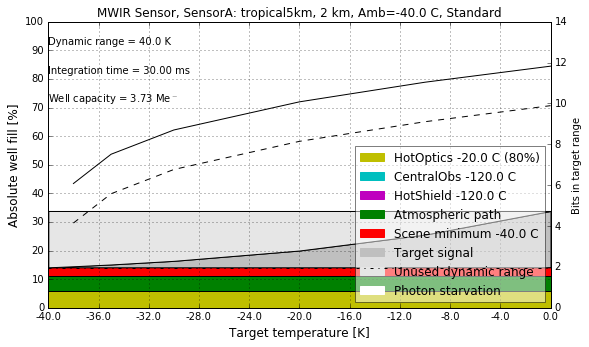

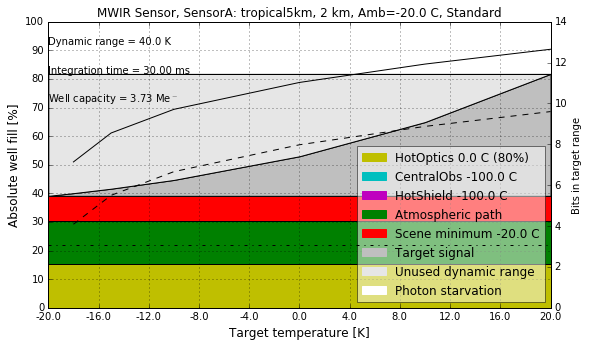

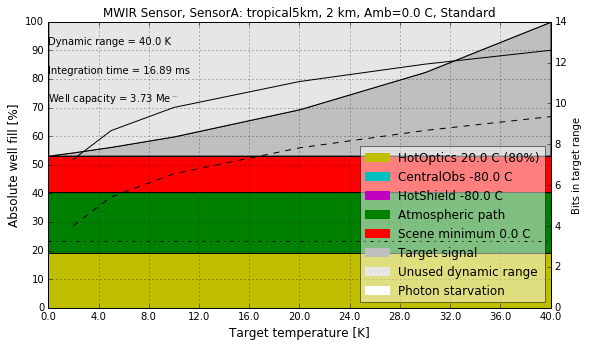

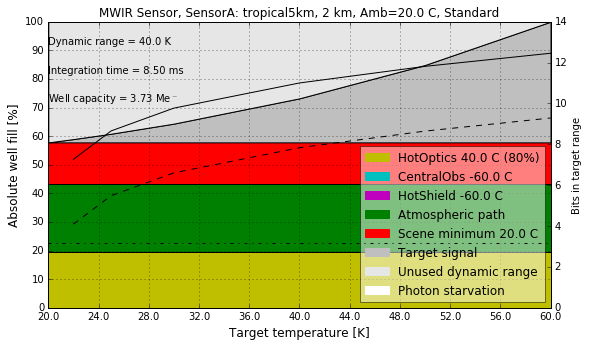

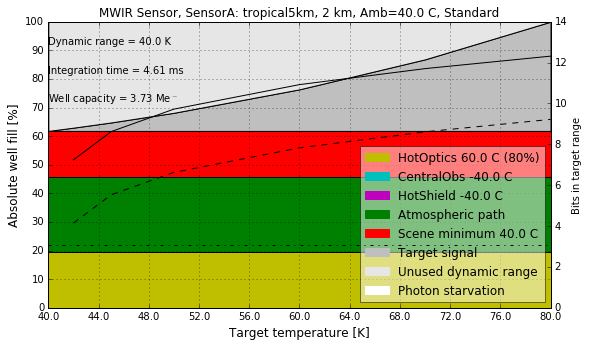

In [36]:
# to calculate and plot the results for different ambient temperatures
iplot=1
ttarget = TempTargetDeltaC
# only do for SensorA
sensors = [dfConcept.columns.values[0]]

for tinternal in [2]:
    for trange in [2]:
        for thotshield in [0]:
            for tcentralObs in [0]:
                for dynamicRangeK in [indexTempDynamicPlot]:
                    for atmo in ['tropical5km','MLS23km','SW31km']:
                        for tambient in [0,1,2,3,4]:
                            doPlots = True if atmo in 'tropical5km' else False
                            iplot += 1
                            dfBitsLoss = plotPWellFillTargetContrast(sensors=sensors,
                                            dfBitsLoss=dfBitsLoss,
                                            dfConcept=dfConcept, 
                                            atmoSet=[atmo], 
                                            tambient=tempAmbUnique[tambient], 
                                            thotshield=tempHotShieldDeltas[thotshield],
                                            tinternal=tempInternDeltas[tinternal],
                                            tcentralObs=tempCentralObsDeltas[tcentralObs],
                                            trange=pathlenUniqueGen[trange], 
                                            optFilter=optFilters[0],
                                            atmotype='gen', 
                                            intTime=integrationTime, 
                                            areaDetector=areaDetector,
                                            wellCapacity=wellCapacityUsable,
                                            dynamicRangeK=tempDynamicDeltas[dynamicRangeK],
                                            ttarget=ttarget,
                                            threshold2Noise=threshold2Noise,
                                            netdstd=netdstd,ksys=ksyss[-1],
                                            doPlots=doPlots,iplot=iplot)



### Well Fill vs Target Distance

The next set of graphs consider well fill for different target distances, against constant backgrounds.

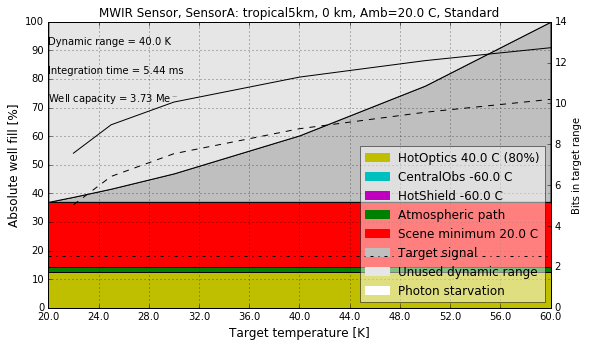

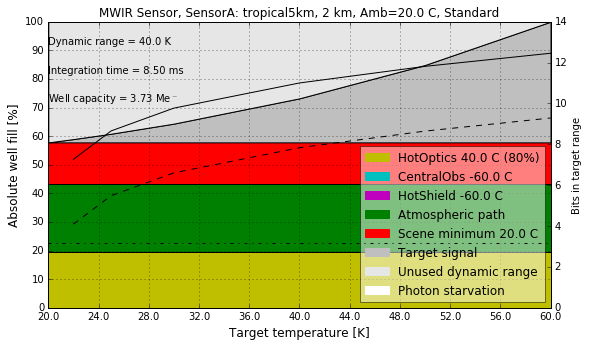

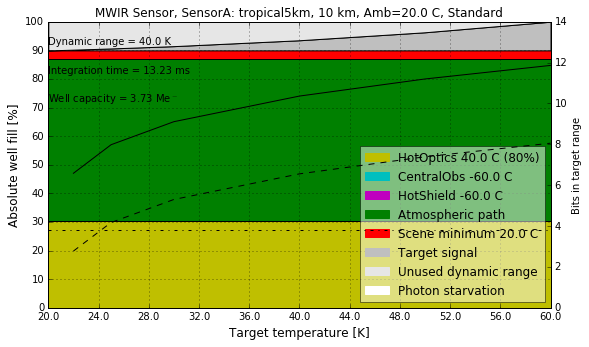

In [37]:
# to calculate and plot the results for different ambient temperatures
iplot=1
ttarget = TempTargetDeltaC
# only do for SensorA
sensors = [dfConcept.columns.values[0]]

for tinternal in [2]:
    for thotshield in [0]:
        for tcentralObs in [0]:
            for dynamicRangeK in [indexTempDynamicPlot]:
                for tambient in [3]:
                    for atmo in ['tropical5km','MLS23km','SW31km']:
                        for trange in [0,2,10]:
                            doPlots = True if atmo in 'tropical5km' else False
                            iplot += 1
                            dfBitsLoss = plotPWellFillTargetContrast(sensors=sensors,
                                            dfBitsLoss=dfBitsLoss,
                                            dfConcept=dfConcept, 
                                            atmoSet=[atmo], 
                                            tambient=tempAmbUnique[tambient], 
                                            thotshield=tempHotShieldDeltas[thotshield],
                                            tinternal=tempInternDeltas[tinternal],
                                            tcentralObs=tempCentralObsDeltas[tcentralObs],
                                            trange=pathlenUniqueGen[trange], 
                                            optFilter=optFilters[0],
                                            atmotype='gen', 
                                            intTime=integrationTime, 
                                            areaDetector=areaDetector,
                                            wellCapacity=wellCapacityUsable,
                                            dynamicRangeK=tempDynamicDeltas[dynamicRangeK],
                                            ttarget=ttarget,
                                            threshold2Noise=threshold2Noise,
                                            netdstd=netdstd,ksys=ksyss[-1],
                                            doPlots=doPlots,iplot=iplot)



### Comparison Between Wide Filter and Notch Filter

The notch filter provides a potential improvement in sensor performance by suppression the atmospheric path radiance and the hot optics sensor radiance in the path radiance spectral range.  The lower flux transmitted by the notch filter reduces the well fill in the detector.

This scenario compares two cold filter configurations by the ratio of bits on target, including all well fill and noise considerations - pretty much the final bits visible to the user.  The filter has most effect at longer ranges where the path radiance increases.

In [38]:
# to calculate and plot the ratio of bits on target for the two different filter types
def plotTvsNotch(dfBitsLoss,dfConcept, atmoSet, tambient, thotshield,  tinternal,dynamicRangeK,
                 tcentralObs, ttarget, atmotype,iplot=1):
    """This function extracts/filters data from the dataframe, so all temperatures must be exact 
    matches to the temperatures in the dataframe.
    """

    p = ryplot.Plotter(iplot,1,1,figsize=(12,4))
#     for i,sensor in enumerate(['SensorA','SensorB']):
    for i,sensor in enumerate(['SensorA']):
        for j,katmo in enumerate(atmoSet):
            df = dfBitsLoss.copy()
            filt = (df.DataSet=='plotPWellFillRange') & \
                (df.Atmo==katmo) & (df.Sensor==sensor) & (df['TempAmbient [K]']==tambient) & \
                (df['TempHotShield [K]']==tambient+thotshield+tinternal) & \
                (df['TempCentralObs [K]']==tambient+tcentralObs+tinternal) & \
                (df['TempIntern [K]']==tambient+tinternal) & \
                (df['dynamicRangeK']==dynamicRangeK) & \
                (df['DeltaTarget']==ttarget) #& \

            df = df[filt]
            df = df.sort_values(by='PathLen')
#             print(df)

            P = df[df.OptFilter=='Notch'].as_matrix(['PathLen'])
            N = df[df.OptFilter=='Notch'].as_matrix(['TargDiffbitsNoise'])
            S = df[df.OptFilter=='Standard'].as_matrix(['TargDiffbitsNoise'])

            spidx = j+2*i+1
            title='Bits on target with/out notch filter: Tamb={} C, $\Delta$Tint={}, $\Delta$Ttar={}'.format(
                tambient-273., tinternal,ttarget )
            label='{} {} '.format(sensor, katmo )
            p.plot(1,P, N/S, title,'Target Range [km]','Improvement with notch', 
                        label=[label],legendLoc='lower right',legendAlpha=0.5)



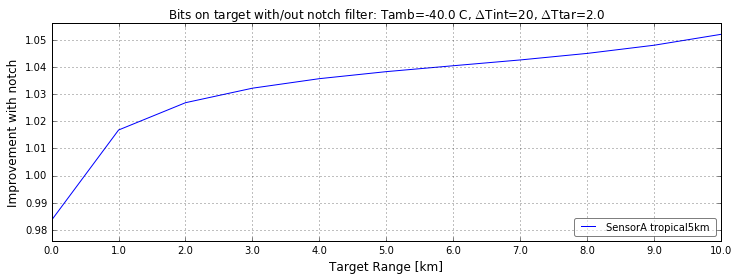

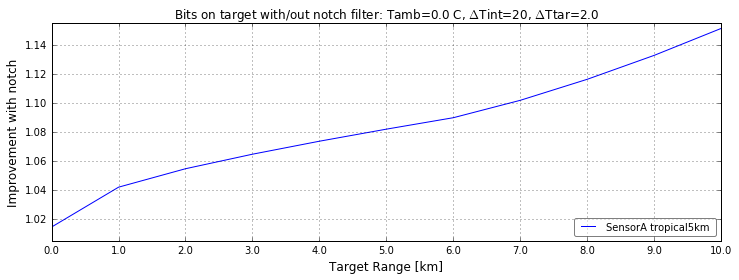

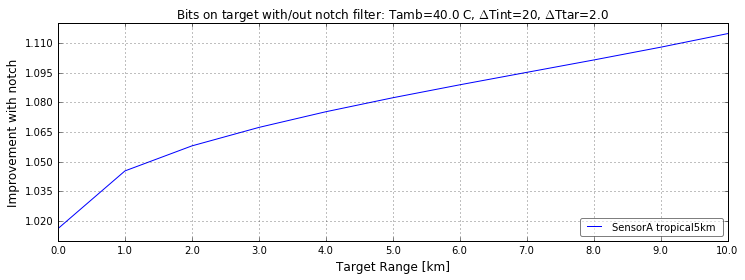

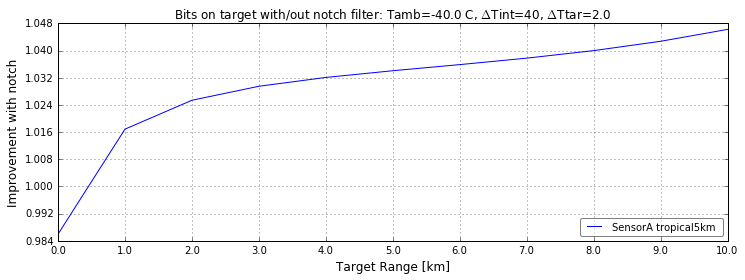

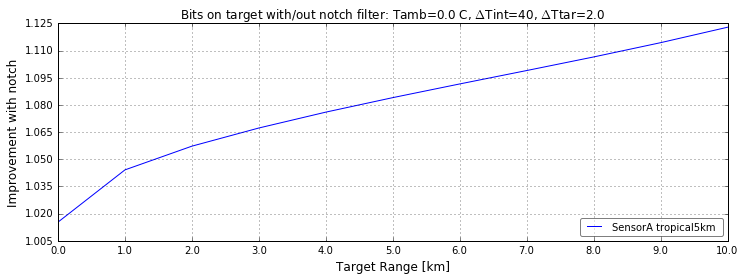

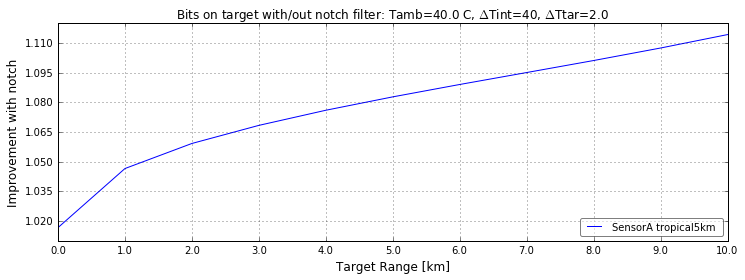

In [39]:
# to calculate and plot the improvement with the notch filter
plotnotchwellfill = False
 
ttarget = TempTargetDeltaC
thotshield = tempHotShieldDeltas[0]
tcentralObs = tempCentralObsDeltas[1]
dynamicRangeK = TempDynamicPlot
atmoUnique = ['tropical5km']
# only do for SensorA
sensors = [dfConcept.columns.values[0]]

iplot = 1
for iint in [2,3]:
    for itamb in [0,2,4]:
        for iff in range(0,len(optFilters)):
            dfBitsLoss = plotPWellFillRange(sensors=sensors,dfBitsLoss=dfBitsLoss, dfConcept=dfConcept, 
                            atmoSet=['tropical5km'], tambient=tempAmbUnique[itamb], thotshield=thotshield,
                            tinternal=tempInternDeltas[iint],tcentralObs=tcentralObs,ttarget=ttarget, 
                            optFilter=optFilters[iff], atmotype='gen', intTime=integrationTime, 
                            areaDetector=areaDetector,wellCapacity=wellCapacityUsable, 
                            dynamicRangeK=dynamicRangeK,threshold2Noise=threshold2Noise,netdstd=netdstd,
                            ksys=ksyss[-1],doPlots=plotnotchwellfill)
        dfBitsLoss.drop_duplicates(inplace=True)
        plotTvsNotch(dfBitsLoss=dfBitsLoss,dfConcept=dfConcept, atmoSet=atmoUnique, tambient=tempAmbUnique[itamb], 
                     thotshield=thotshield,tinternal=tempInternDeltas[iint],dynamicRangeK=dynamicRangeK,
                     tcentralObs=tcentralObs,ttarget=ttarget, atmotype='gen', iplot=iplot) 
        iplot += 1


## Bit Dynamic Range

The number of bits available to represent the dynamic range of the scene was extracted from the preceding graphs.  These numbers are the 14 bits of the ADC minus the bits lost to noise and the bits lost to non-scene well fill, NUC headroom and photon starvation.  

The tables below state the number of available bits for path lengths of 0 km and 10 km.  The sensor operating at any range in between will have the number of bits in the stated range.

The statistics of all the samples calculated in this report:

In [40]:
# to calculate the statistics of all the samples in this report

print('Statistical analysis of all the samples in this report:')
print('Minimum = {} bits'.format(dfBitsLoss['BitsAvail'].min()))
print('Maximum = {} bits'.format(dfBitsLoss['BitsAvail'].max()))
print('Mean = {} bits'.format(dfBitsLoss['BitsAvail'].mean()))
print('StdDev = {} bits'.format(dfBitsLoss['BitsAvail'].std()))
print('Sample count = {}'.format(dfBitsLoss['BitsAvail'].count()))


Statistical analysis of all the samples in this report:
Minimum = -inf bits
Maximum = 11.8977958509 bits
Mean = -inf bits
StdDev = nan bits
Sample count = 433


In [41]:
# to calculate the scenario where the lowest number of available bits occurred.

print(dfBitsLoss.ix[np.argmin(np.abs(dfBitsLoss['BitsAvail'] - 0.0))])

DataSet                   plotPWellFillTargetContrast
Atmo                                      tropical5km
AtmoDesc                     Tropical, 5 km urban vis
Sensor                                        SensorA
PathLen                                            10
TempAmbient [C]                                    20
TempInsideDelta [C]                                20
nubitloss                                   -0.415037
wellfillbitloss                               -1.7241
BitsNoFill                                    6.58309
wellfillNETD                                0.0853983
BitsNETD                                       3.8065
BitsAvail                                      2.7766
TempAmbient [K]                                   293
TempHotShield [K]                                 213
TempCentralObs [K]                                213
TempIntern [K]                                    313
OptFilter                                    Standard
Gain                        

In [42]:
# to display unique values
print(dfBitsLoss.columns)
print(dfBitsLoss['DataSet'].unique())
print(' ')
for dataset in dfBitsLoss['DataSet'].unique():
    print(dataset)
    print(dfBitsLoss[dfBitsLoss.DataSet==dataset]['Atmo'].unique())
    print(dfBitsLoss[dfBitsLoss.DataSet==dataset]['Sensor'].unique())
    print(dfBitsLoss[dfBitsLoss.DataSet==dataset]['PathLen'].unique())
    print(dfBitsLoss[dfBitsLoss.DataSet==dataset]['TempAmbient [C]'].unique())
    print(dfBitsLoss[dfBitsLoss.DataSet==dataset]['TempInsideDelta [C]'].unique())
    print(dfBitsLoss[dfBitsLoss.DataSet==dataset]['dynamicRangeK'].unique())

    print(' ')


Index([u'DataSet', u'Atmo', u'AtmoDesc', u'Sensor', u'PathLen', u'TempAmbient [C]',
       u'TempInsideDelta [C]', u'nubitloss', u'wellfillbitloss', u'BitsNoFill', u'wellfillNETD',
       u'BitsNETD', u'BitsAvail', u'TempAmbient [K]', u'TempHotShield [K]', u'TempCentralObs [K]',
       u'TempIntern [K]', u'OptFilter', u'Gain', u'WellCapacity', u'IntTime', u'atmotype',
       u'areaDetector', u'dynamicRangeK', u'threshold2Noise', u'netdstd', u'ksys',
       u'TempDynamic [C]', u'WfHotOptics', u'WfCentralObs', u'WfEHotShield', u'WfPath', u'WfScene',
       u'WfDynamic', u'WfPhotonStarve', u'EScene [q/(s.m2)]', u'EDynamic [q/(s.m2)]',
       u'wellfillTargDiff', u'TargDiffbitsNoNoise', u'TargDiffbitsNoise',
       u'Mderivscn [q/(s.m2.K)]', u'DeltaTarget'],
      dtype='object')
['plotPWellFillRange' 'plotPWellFillTargetContrast']
 
plotPWellFillRange
['tropical5km' 'MLS23km' 'SW31km']
[u'SensorA']
[0.001 1.0009 2.0008 3.0006999999999997 4.0006 5.000500000000001 6.0004
 7.0003 8.0002 9.00

In [43]:
# to calculate and display the available number of bits for a few test cases
dynamicRangeK = 40.
TempTargetDeltaC = 2.
dfb = dfBitsLoss.copy()
for dataset in dfb['DataSet'].unique():
    rngeU = dfb[dfb.DataSet==dataset]['PathLen'].unique()
    rng0 = rngeU[np.argmin(np.abs(rngeU - 0.0))]
    rng10 = rngeU[np.argmin(np.abs(rngeU - 10.0))]
    for tdyna in dfb[dfb.DataSet==dataset]['dynamicRangeK'].unique():
        for atmo in dfb[dfb.DataSet==dataset]['Atmo'].unique():
            for rng in [rng0, rng10]:

                filt = (dfb.DataSet==dataset) & (dfb.Atmo==atmo)  & (dfb.OptFilter=='Standard') & \
                    (np.abs(dfb['dynamicRangeK']-(tdyna))<0.01) & \
                    (np.abs(dfb['PathLen']-rng)<0.01)  & \
                    (np.abs(dfb['DeltaTarget']-(TempTargetDeltaC))<0.01) 

                dfd = dfb[filt].copy()
                dfd.drop_duplicates(inplace=True)
                dfd = dfd[pd.notnull (dfd['BitsAvail'])]
                if not dfd.empty:
                    print('Atmospheric condition {}'.format(atmo))
                    print('Sensor dynamic range {} K'.format(tdyna))

#                     print(dfd)
                    dfp = pd.pivot_table(dfd, values='BitsAvail', 
                                          index=['TempAmbient [C]', 'TempInsideDelta [C]'], 
                                          columns=['Sensor','PathLen'],aggfunc = lambda x: np.mean(x))
                    print(dfp)
                    print('\n{}\n'.format(80*'*'))


Atmospheric condition tropical5km
Sensor dynamic range 70.0 K
Sensor                                 SensorA
PathLen                                  0.001
TempAmbient [C] TempInsideDelta [C]           
20.0            -100.0               11.897796

********************************************************************************

Atmospheric condition tropical5km
Sensor dynamic range 70.0 K
Sensor                                SensorA
PathLen                                  10.0
TempAmbient [C] TempInsideDelta [C]          
20.0            -100.0               8.611029

********************************************************************************

Atmospheric condition tropical5km
Sensor dynamic range 40.0 K
Sensor                                 SensorA
PathLen                                  0.001
TempAmbient [C] TempInsideDelta [C]           
-40.0           20.0                 10.819596
                40.0                 10.715375
-20.0           20.0                 10.7

# Conclusion

The following observations are made from the results herein:

TBDL

# Python and [module versions, and dates](https://github.com/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [44]:
# you only need to do this once
#!pip install --upgrade version_information

%load_ext version_information
%version_information numpy, scipy, matplotlib, pyradi

Software versions
Python 2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython 5.1.0
OS Windows 7 6.1.7601 SP1
numpy 1.11.1
scipy 0.18.1
matplotlib 1.5.3
pyradi 1.1.0
pandas 0.18.1
Mon Nov 28 17:41:42 2016 South Africa Standard Time